In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 23041
INFO:tensorflow:Using local port 23046
INFO:tensorflow:Using local port 24304
INFO:tensorflow:Using local port 24424
INFO:tensorflow:Using local port 24632
INFO:tensorflow:Using local port 21360
INFO:tensorflow:Using local port 21024
INFO:tensorflow:Using local port 24312
INFO:tensorflow:Using local port 22487
INFO:tensorflow:Using local port 22280
python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

In [4]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [5]:
dataset = dataframe.values

In [6]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

In [7]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

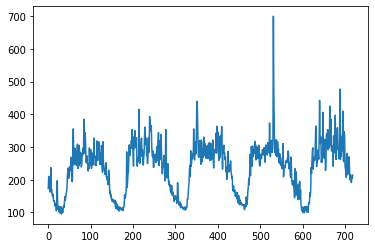

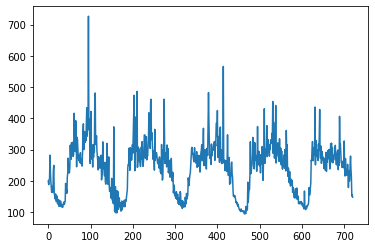

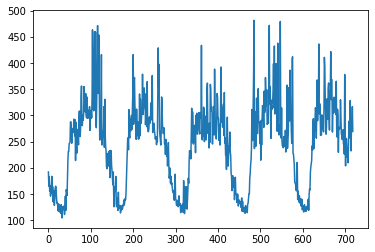

In [8]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


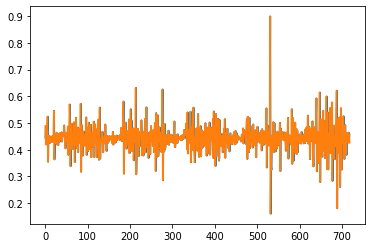

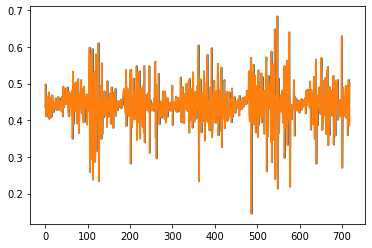

In [9]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [10]:
hunits = 2

In [81]:
lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]

    predictions.append(yhat)

count = 1
for i in range(len(test_scaled)):
    if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.15)) :
        count+=1
print('%d; %.3f; %d; %d; %.2f \n' % (hunits, 0.15, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
2; 0.150; 69; 217; 719.00 



In [15]:
lstm_model.layers[1].get_weights()
            

[array([[ 0.51897496],
        [-0.6401372 ]], dtype=float32),
 array([0.27282792], dtype=float32)]

In [ ]:
layer.set_weights(layer1.get_weights())

In [16]:
round(1234, -3)

1000

In [80]:
lstm_model.layers[0].get_weights()

[array([[ 1.16,  0.28, -0.29, -0.62,  0.51,  0.29,  0.16, -0.5 ]],
       dtype=float32),
 array([[ 0.25, -0.1 , -0.39, -0.25,  0.82, -0.02, -0.09, -0.19],
        [-0.59,  0.3 , -0.27, -0.15,  0.12,  0.22, -0.38,  0.51]],
       dtype=float32),
 array([ 0.61, -0.03,  1.  ,  1.  ,  0.51, -0.26,  0.6 , -0.03],
       dtype=float32)]

In [102]:
file_object =  open('results_float_2.csv', 'w')
file_object.write("Hunit; float; Proportion; Count; Total \n")

40

In [103]:
for hunits in range(1,30):

    lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    for precision in range(1,9):
        
        for layer in lstm_model.layers:
            a = layer.get_weights()
            index = 0
            for sublayers in a:
                a[index] = np.around(sublayers, 9-precision)
                index +=1
            layer.set_weights(a)
            print(layer.get_weights())
        
        # walk-forward validation on the test data
        predictions = list()
        for i in range(len(test_scaled)):
            # make one-step forecast
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            expected = raw_values[len(train) + i + 1]

            predictions.append(yhat)

        count = 1
        for i in range(len(test_scaled)):
            if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.15)) :
                count+=1
        file_object.write('%d; %d; %.2f; %d; %d \n' % (hunits, 9-precision, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.09866438, -1.0443851 ,  0.17619757,  1.0486101 ]],
      dtype=float32), array([[-0.17305183, -0.53263724,  0.7160579 ,  0.41666737]],
      dtype=float32), array([0.38481963, 1.        , 0.27533674, 0.40731204], dtype=float32)]
[array([[1.4523051]], dtype=float32), array([0.23391014], dtype=float32)]
[array([[ 0.0986644, -1.0443851,  0.1761976,  1.0486101]], dtype=float32), array([[-0.1730518, -0.5326372,  0.7160579,  0.4166674]], dtype=float32), array([0.3848196, 1.       , 0.2753368, 0.

[array([[-0.5835801,  0.5135158,  0.4583164,  0.2268373, -0.670069 ,
        -0.6616998, -0.157997 , -0.273751 ,  0.0936524, -0.5111968,
         0.1328407,  0.466614 ]], dtype=float32), array([[ 0.5275595, -0.4318031,  0.0041303,  0.1503127, -0.1360688,
         0.1345929,  0.12684  ,  0.47273  , -0.389122 ,  0.2610524,
        -0.121865 , -0.0448188],
       [-0.3908599, -0.2732694,  0.0799075,  0.3154068,  0.0632323,
         0.4774248,  0.0864458,  0.1505334,  0.3245148,  0.1791202,
        -0.043377 ,  0.515116 ],
       [ 0.0572656,  0.4788176, -0.0547046,  0.486953 , -0.3762213,
        -0.0612779,  0.2975709, -0.1889448, -0.0556151,  0.1326445,
        -0.4826688,  0.064311 ]], dtype=float32), array([ 0.0478336,  0.3680787,  0.1306887,  1.       ,  1.       ,
        1.       ,  0.2230159, -0.2607702, -0.217406 ,  0.0487059,
        0.360682 ,  0.1312932], dtype=float32)]
[array([[ 0.6774592],
       [-1.188427 ],
       [-0.6067512]], dtype=float32), array([0.2191464], dtype=f

[array([[ 0.428313,  0.531155,  0.001491,  0.204444, -0.139814, -0.233758,
        -0.276751, -0.107274, -0.287077, -0.717493, -0.603183, -0.463888,
        -0.005986, -0.173727,  0.059076,  0.655742]], dtype=float32), array([[ 0.10555 ,  0.118537,  0.151233, -0.275435,  0.063098,  0.052932,
         0.019386,  0.312852, -0.468694,  0.140499, -0.249962, -0.39496 ,
        -0.263309, -0.289182,  0.396476,  0.054746],
       [ 0.076587,  0.135769,  0.191054, -0.134749,  0.057089, -0.607121,
        -0.288768, -0.246281,  0.475713,  0.142995, -0.242423, -0.086813,
        -0.162527, -0.242357,  0.049837, -0.066744],
       [ 0.390182,  0.06541 ,  0.357684, -0.08946 , -0.140673, -0.099954,
         0.13169 ,  0.004191, -0.144078,  0.221271, -0.344122,  0.214821,
         0.259996,  0.318358, -0.206782,  0.463038],
       [-0.024823, -0.13596 , -0.170471, -0.237274, -0.150293,  0.22468 ,
        -0.096937, -0.124183,  0.185326,  0.039224, -0.162961,  0.215184,
        -0.617602,  0.466107, 

[array([[ 0.4634112, -0.0358386, -0.2848175,  0.5805164, -0.3148744,
        -0.0964227, -0.0232955, -0.2945354,  0.0487917, -0.5272946,
        -0.2314572, -0.0506615,  0.2782657, -0.4943196,  0.5841159,
        -0.334441 ,  0.6397386, -0.3612216,  0.622091 ,  0.2052972]],
      dtype=float32), array([[-0.0313454, -0.1325654,  0.0987045, -0.2505268,  0.0611986,
        -0.3942619, -0.3248245,  0.0640146, -0.2475006, -0.1964471,
        -0.0357344, -0.1838954, -0.3807211, -0.2092979, -0.1322096,
        -0.1583843, -0.0829936, -0.4380189, -0.2260775, -0.1549837],
       [ 0.0974048, -0.0706144, -0.3829171,  0.3792842, -0.1170258,
         0.1204557, -0.4309301,  0.0324788,  0.0406344,  0.2302917,
        -0.0062302, -0.0129346,  0.0450071, -0.0948911,  0.1706332,
         0.0871301,  0.1037391, -0.4096766, -0.0974896,  0.4351482],
       [-0.1451249,  0.0398186, -0.1938496, -0.4860863, -0.1665242,
        -0.292767 , -0.1754576, -0.2512005,  0.2851808,  0.165127 ,
        -0.020929 ,  

[array([[ 0.46, -0.04, -0.28,  0.58, -0.32, -0.1 , -0.02, -0.29,  0.05,
        -0.53, -0.23, -0.05,  0.28, -0.49,  0.58, -0.33,  0.64, -0.36,
         0.62,  0.2 ]], dtype=float32), array([[-0.03, -0.13,  0.1 , -0.25,  0.06, -0.39, -0.32,  0.06, -0.25,
        -0.2 , -0.04, -0.18, -0.38, -0.21, -0.13, -0.16, -0.08, -0.44,
        -0.23, -0.16],
       [ 0.1 , -0.07, -0.38,  0.38, -0.12,  0.12, -0.43,  0.03,  0.04,
         0.23, -0.01, -0.01,  0.04, -0.1 ,  0.17,  0.09,  0.1 , -0.41,
        -0.1 ,  0.44],
       [-0.14,  0.04, -0.19, -0.49, -0.17, -0.29, -0.18, -0.25,  0.28,
         0.16, -0.02,  0.22, -0.22,  0.01,  0.04,  0.33, -0.14,  0.28,
        -0.1 ,  0.28],
       [-0.01, -0.16, -0.4 , -0.19, -0.03,  0.11, -0.09,  0.2 , -0.24,
         0.04,  0.43, -0.15,  0.08,  0.2 ,  0.17,  0.17,  0.23,  0.19,
        -0.34, -0.37],
       [-0.3 ,  0.44,  0.06,  0.38,  0.06, -0.16,  0.02,  0.28,  0.06,
         0.21,  0.4 ,  0.16, -0.38, -0.14, -0.17,  0.1 ,  0.06,  0.07,
         0.01, 

[array([[-0.430498,  0.38961 ,  0.371758,  0.330863,  0.2798  , -0.23898 ,
        -0.296101, -0.475715, -0.334512, -0.166694, -0.402046, -0.196865,
         0.487108,  0.410001,  0.425457,  0.161552, -0.176297, -0.253405,
        -0.162144,  0.133487, -0.226767,  0.109352,  0.042904, -0.387639]],
      dtype=float32), array([[-0.011984, -0.377317, -0.314636,  0.173471,  0.15335 ,  0.122256,
        -0.126102, -0.028842, -0.281545, -0.10523 , -0.025644,  0.009523,
         0.330094,  0.266822, -0.165359,  0.259017, -0.041694,  0.084275,
        -0.196856, -0.12056 , -0.038718, -0.102243, -0.165003, -0.454114],
       [ 0.002258,  0.136769, -0.210129, -0.137448,  0.156661, -0.290836,
         0.0528  , -0.159461, -0.173503, -0.073921,  0.315486, -0.364117,
        -0.051589, -0.242179, -0.15216 ,  0.040156,  0.16607 ,  0.113805,
         0.029251, -0.020933,  0.377812,  0.187147,  0.371691, -0.263433],
       [ 0.277717, -0.142415,  0.112015,  0.405106, -0.158495, -0.006191,
         0.

[array([[-0.43,  0.39,  0.37,  0.33,  0.28, -0.24, -0.3 , -0.48, -0.33,
        -0.17, -0.4 , -0.2 ,  0.49,  0.41,  0.43,  0.16, -0.18, -0.25,
        -0.16,  0.13, -0.23,  0.11,  0.04, -0.39]], dtype=float32), array([[-0.01, -0.38, -0.32,  0.17,  0.15,  0.12, -0.13, -0.03, -0.28,
        -0.1 , -0.03,  0.01,  0.33,  0.27, -0.16,  0.26, -0.04,  0.08,
        -0.2 , -0.12, -0.04, -0.1 , -0.16, -0.45],
       [ 0.  ,  0.14, -0.21, -0.14,  0.16, -0.29,  0.05, -0.16, -0.17,
        -0.07,  0.32, -0.36, -0.05, -0.24, -0.15,  0.04,  0.17,  0.11,
         0.03, -0.02,  0.38,  0.19,  0.37, -0.26],
       [ 0.28, -0.14,  0.11,  0.4 , -0.16, -0.01,  0.54, -0.08, -0.31,
         0.22, -0.08, -0.2 , -0.13, -0.02, -0.08, -0.25,  0.05,  0.14,
        -0.3 ,  0.02,  0.  ,  0.02, -0.05,  0.07],
       [-0.33,  0.23, -0.21,  0.28, -0.08,  0.45, -0.29, -0.3 , -0.04,
         0.15,  0.01, -0.36, -0.14,  0.03,  0.1 ,  0.01,  0.17,  0.17,
         0.08,  0.08,  0.12, -0.08, -0.19,  0.17],
       [ 0.19, -0

[array([[ 0.107418,  0.314794, -0.20144 ,  0.115982,  0.397564,  0.423256,
        -0.172535,  0.145515,  0.351953, -0.229506, -0.029338, -0.272287,
         0.303053, -0.23224 ,  0.614226,  0.453738,  0.094009, -0.132873,
         0.501949, -0.379614, -0.386812,  0.064067, -0.117032, -0.168661,
        -0.210591,  0.295755,  0.258166, -0.061537]], dtype=float32), array([[-0.130152,  0.052662, -0.224576,  0.272784,  0.489947,  0.008234,
        -0.02395 , -0.016026,  0.125429,  0.015803, -0.398795,  0.246979,
        -0.155782,  0.23291 , -0.073328, -0.037862,  0.065996,  0.356353,
        -0.192252, -0.208721,  0.028854,  0.144793,  0.02493 ,  0.03262 ,
         0.05713 ,  0.148944,  0.075874, -0.163085],
       [-0.094057, -0.039736,  0.224776,  0.049927, -0.219508,  0.019081,
         0.373752,  0.264706, -0.409436,  0.039716, -0.269909,  0.040806,
         0.233729, -0.094   ,  0.188534, -0.113141,  0.036458,  0.070666,
        -0.272819, -0.003302,  0.308035,  0.08018 ,  0.10311 ,

[array([[ 0.107,  0.315, -0.201,  0.116,  0.398,  0.423, -0.172,  0.146,
         0.352, -0.23 , -0.029, -0.272,  0.303, -0.232,  0.614,  0.454,
         0.094, -0.133,  0.502, -0.38 , -0.387,  0.064, -0.117, -0.169,
        -0.211,  0.296,  0.258, -0.062]], dtype=float32), array([[-0.13 ,  0.053, -0.225,  0.273,  0.49 ,  0.008, -0.024, -0.016,
         0.125,  0.016, -0.399,  0.247, -0.156,  0.233, -0.073, -0.038,
         0.066,  0.356, -0.192, -0.209,  0.029,  0.145,  0.025,  0.033,
         0.057,  0.149,  0.076, -0.163],
       [-0.094, -0.04 ,  0.225,  0.05 , -0.22 ,  0.019,  0.374,  0.265,
        -0.409,  0.04 , -0.27 ,  0.041,  0.234, -0.094,  0.188, -0.113,
         0.036,  0.071, -0.273, -0.003,  0.308,  0.08 ,  0.103,  0.119,
         0.009, -0.108,  0.206, -0.248],
       [-0.38 ,  0.294, -0.329,  0.149, -0.123,  0.087,  0.12 , -0.222,
         0.036, -0.044, -0.041, -0.056,  0.279, -0.079,  0.039, -0.09 ,
         0.012, -0.254,  0.22 , -0.303, -0.057,  0.072,  0.231, -0.

[array([[ 0.3653469, -0.0786178, -0.1726085, -0.1118407,  0.4016499,
        -0.3055678,  0.0944698, -0.2376877,  0.1234055, -0.4057064,
        -0.220394 ,  0.351634 ,  0.2247214,  0.2956928,  0.296194 ,
         0.300704 ,  0.0399762,  0.5084719,  0.1300086,  0.4506562,
         0.0796314, -0.3584659,  0.2090308,  0.3887915,  0.4814709,
         0.1638912,  0.313096 ,  0.0610264, -0.0573801,  0.5121271,
         0.2895455,  0.0115367]], dtype=float32), array([[-7.708000e-04, -6.360940e-02, -2.370070e-02,  3.460700e-03,
         1.653144e-01,  1.419573e-01, -4.321300e-03, -1.624530e-01,
        -1.463101e-01,  1.357110e-01, -9.263100e-02, -1.010788e-01,
        -8.252800e-03, -2.796624e-01, -3.168868e-01, -2.709171e-01,
         2.363612e-01, -2.164844e-01, -3.599888e-01, -1.883778e-01,
        -1.032397e-01, -2.747344e-01, -1.275163e-01, -1.539797e-01,
        -5.826290e-02,  4.119960e-02,  1.822003e-01,  4.400150e-02,
        -7.045610e-02, -5.319250e-02,  3.326079e-01,  2.412693e-0

[array([[ 0.36535, -0.07862, -0.17261, -0.11184,  0.40165, -0.30557,
         0.09447, -0.23769,  0.12341, -0.40571, -0.22039,  0.35163,
         0.22472,  0.29569,  0.29619,  0.3007 ,  0.03998,  0.50847,
         0.13001,  0.45066,  0.07963, -0.35847,  0.20903,  0.38879,
         0.48147,  0.16389,  0.3131 ,  0.06103, -0.05738,  0.51213,
         0.28955,  0.01154]], dtype=float32), array([[-7.7000e-04, -6.3610e-02, -2.3700e-02,  3.4600e-03,  1.6531e-01,
         1.4196e-01, -4.3200e-03, -1.6245e-01, -1.4631e-01,  1.3571e-01,
        -9.2630e-02, -1.0108e-01, -8.2500e-03, -2.7966e-01, -3.1689e-01,
        -2.7092e-01,  2.3636e-01, -2.1648e-01, -3.5999e-01, -1.8838e-01,
        -1.0324e-01, -2.7473e-01, -1.2752e-01, -1.5398e-01, -5.8260e-02,
         4.1200e-02,  1.8220e-01,  4.4000e-02, -7.0460e-02, -5.3190e-02,
         3.3261e-01,  2.4127e-01],
       [-2.1810e-02, -9.9740e-02, -1.6912e-01, -1.9985e-01, -1.9886e-01,
        -6.0040e-02,  1.2906e-01,  4.0290e-02, -1.6041e-01, -3.4500

[array([[ 0.365, -0.079, -0.173, -0.112,  0.402, -0.306,  0.094, -0.238,
         0.123, -0.406, -0.22 ,  0.352,  0.225,  0.296,  0.296,  0.301,
         0.04 ,  0.508,  0.13 ,  0.451,  0.08 , -0.358,  0.209,  0.389,
         0.482,  0.164,  0.313,  0.061, -0.057,  0.512,  0.29 ,  0.012]],
      dtype=float32), array([[-0.001, -0.064, -0.024,  0.004,  0.165,  0.142, -0.004, -0.162,
        -0.146,  0.136, -0.093, -0.101, -0.008, -0.28 , -0.317, -0.271,
         0.236, -0.216, -0.36 , -0.188, -0.103, -0.275, -0.128, -0.154,
        -0.058,  0.041,  0.182,  0.044, -0.07 , -0.053,  0.333,  0.241],
       [-0.022, -0.1  , -0.169, -0.2  , -0.199, -0.06 ,  0.129,  0.04 ,
        -0.16 , -0.034,  0.152,  0.225, -0.26 , -0.005,  0.002, -0.093,
        -0.368, -0.004,  0.167, -0.062,  0.159,  0.262, -0.294,  0.086,
         0.164, -0.   ,  0.279,  0.063,  0.022, -0.167,  0.397,  0.182],
       [-0.11 , -0.216,  0.184, -0.447,  0.283,  0.039,  0.125, -0.01 ,
         0.135, -0.177, -0.147, -0.16

(1439, 1, 1)
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (1, 9)                    396       
_________________________________________________________________
output (Dense)               (1, 1)                    10        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.09927542,  0.4398947 ,  0.3230544 ,  0.06393622, -0.40511584,
         0.38104472,  0.3937292 , -0.0567882 ,  0.02945014,  0.2845028 ,
        -0.04159838, -0.02622387,  0.15619761,  0.09453243, -0.06410593,
        -0.37584415, -0.21774228, -0.33459514, -0.06631872, -0.05793806,
         0.09083411, -0.23156077,  0.17743655, -0.52736115,  0.29298803,
         0.45561376,  0.07037472,  0.23873147,  0.5269289 , -0.00204168,
        -0.04429901, -0.13961557,  0.17208485,  0.04596568,  0.37

[array([[ 0.099275,  0.439895,  0.323054,  0.063936, -0.405116,  0.381045,
         0.393729, -0.056788,  0.02945 ,  0.284503, -0.041598, -0.026224,
         0.156198,  0.094532, -0.064106, -0.375844, -0.217742, -0.334595,
        -0.066319, -0.057938,  0.090834, -0.231561,  0.177437, -0.527361,
         0.292988,  0.455614,  0.070375,  0.238732,  0.526929, -0.002042,
        -0.044299, -0.139616,  0.172085,  0.045966,  0.371348, -0.311003]],
      dtype=float32), array([[ 0.436023, -0.11318 ,  0.005834, -0.404832, -0.103178,  0.001645,
        -0.187017, -0.078344,  0.24927 , -0.164643, -0.140646,  0.014824,
         0.078337,  0.151882, -0.055359, -0.165397, -0.211337, -0.030097,
        -0.076264, -0.073936, -0.103637,  0.026145,  0.001183,  0.103528,
        -0.089752,  0.247708,  0.262658,  0.285618, -0.026682,  0.0047  ,
        -0.213269,  0.12898 , -0.088736,  0.045809,  0.19721 , -0.042717],
       [ 0.02225 ,  0.054446, -0.158351, -0.14917 , -0.156008,  0.093298,
        -0.0

[array([[ 0.0993,  0.4399,  0.323 ,  0.0639, -0.4051,  0.381 ,  0.3937,
        -0.0568,  0.0294,  0.2845, -0.0416, -0.0262,  0.1562,  0.0945,
        -0.0641, -0.3758, -0.2177, -0.3346, -0.0663, -0.0579,  0.0908,
        -0.2316,  0.1774, -0.5274,  0.293 ,  0.4556,  0.0704,  0.2387,
         0.5269, -0.002 , -0.0443, -0.1396,  0.1721,  0.046 ,  0.3714,
        -0.311 ]], dtype=float32), array([[ 0.436 , -0.1132,  0.0058, -0.4048, -0.1032,  0.0016, -0.187 ,
        -0.0783,  0.2493, -0.1646, -0.1406,  0.0148,  0.0783,  0.1519,
        -0.0554, -0.1654, -0.2113, -0.0301, -0.0763, -0.0739, -0.1036,
         0.0261,  0.0012,  0.1035, -0.0898,  0.2477,  0.2627,  0.2856,
        -0.0267,  0.0047, -0.2133,  0.129 , -0.0887,  0.0458,  0.1972,
        -0.0427],
       [ 0.0222,  0.0544, -0.1584, -0.1492, -0.156 ,  0.0933, -0.0167,
        -0.2148, -0.2439,  0.0631,  0.1007, -0.1623, -0.073 ,  0.0516,
        -0.1884, -0.1374,  0.0284,  0.2251,  0.0576, -0.3766, -0.0514,
        -0.1878, -0.008

[array([[ 0.1 ,  0.44,  0.32,  0.06, -0.4 ,  0.38,  0.39, -0.06,  0.03,
         0.28, -0.04, -0.03,  0.16,  0.09, -0.06, -0.38, -0.22, -0.34,
        -0.07, -0.06,  0.09, -0.23,  0.18, -0.53,  0.29,  0.46,  0.07,
         0.24,  0.53, -0.  , -0.04, -0.14,  0.17,  0.05,  0.37, -0.31]],
      dtype=float32), array([[ 0.44, -0.11,  0.01, -0.4 , -0.1 ,  0.  , -0.19, -0.08,  0.25,
        -0.16, -0.14,  0.02,  0.08,  0.15, -0.06, -0.16, -0.21, -0.03,
        -0.08, -0.07, -0.1 ,  0.03,  0.  ,  0.1 , -0.09,  0.25,  0.26,
         0.29, -0.03,  0.  , -0.21,  0.13, -0.09,  0.05,  0.2 , -0.04],
       [ 0.02,  0.05, -0.16, -0.15, -0.16,  0.09, -0.02, -0.22, -0.24,
         0.06,  0.1 , -0.16, -0.07,  0.05, -0.19, -0.14,  0.03,  0.22,
         0.06, -0.38, -0.05, -0.19, -0.01, -0.15,  0.08, -0.25,  0.12,
         0.02,  0.22,  0.23, -0.26, -0.28, -0.04, -0.28, -0.05,  0.18],
       [ 0.07,  0.1 ,  0.04, -0.06,  0.11,  0.28, -0.14, -0.34, -0.21,
        -0.18,  0.22, -0.04, -0.09, -0.02,  0.1 , 

[array([[ 0.0804742, -0.1152784, -0.0676819,  0.234185 , -0.1395216,
        -0.3926709,  0.3443184, -0.0078653,  0.4716292,  0.3447104,
        -0.118854 , -0.1919953,  0.3446488,  0.041122 , -0.0344606,
        -0.3298303, -0.2876914, -0.323108 , -0.1089025,  0.1629704,
         0.2012541, -0.1031761,  0.2000524, -0.1546313, -0.185385 ,
         0.1037806, -0.3029108,  0.3478708,  0.3213785,  0.2467946,
         0.0647149, -0.1357943, -0.0273903, -0.114937 ,  0.0132799,
         0.2231258,  0.3468902, -0.0553123, -0.0199142,  0.5085264]],
      dtype=float32), array([[ 0.1038222,  0.0702993,  0.0726643, -0.0997627, -0.2147616,
        -0.2495372, -0.035759 ,  0.0147586,  0.3391022,  0.0032853,
        -0.0928524,  0.1556037, -0.2537232,  0.0867491, -0.0673643,
        -0.0772269, -0.0139357,  0.127394 , -0.1408231,  0.198805 ,
        -0.2727668,  0.0334431,  0.0620886,  0.1607255, -0.2376666,
        -0.170913 , -0.1480554,  0.0387434,  0.0789887,  0.1573987,
         0.0739393, -0.

[array([[ 0.08047, -0.11528, -0.06768,  0.23418, -0.13952, -0.39267,
         0.34432, -0.00786,  0.47163,  0.34471, -0.11885, -0.192  ,
         0.34465,  0.04112, -0.03446, -0.32983, -0.28769, -0.32311,
        -0.1089 ,  0.16297,  0.20125, -0.10318,  0.20005, -0.15463,
        -0.18538,  0.10378, -0.30291,  0.34787,  0.32138,  0.2468 ,
         0.06472, -0.13579, -0.02739, -0.11494,  0.01328,  0.22313,
         0.34689, -0.05531, -0.01991,  0.50853]], dtype=float32), array([[ 0.10382,  0.0703 ,  0.07266, -0.09976, -0.21476, -0.24954,
        -0.03576,  0.01476,  0.3391 ,  0.00328, -0.09285,  0.1556 ,
        -0.25372,  0.08675, -0.06736, -0.07723, -0.01394,  0.12739,
        -0.14082,  0.1988 , -0.27277,  0.03344,  0.06209,  0.16073,
        -0.23767, -0.17091, -0.14806,  0.03874,  0.07899,  0.1574 ,
         0.07394, -0.16437,  0.2581 , -0.32848,  0.04388, -0.07181,
        -0.08748, -0.0155 ,  0.25535, -0.14363],
       [ 0.18222, -0.06834, -0.10278, -0.16323,  0.01494, -0.0404 ,


[array([[ 0.08 , -0.115, -0.068,  0.234, -0.14 , -0.393,  0.344, -0.008,
         0.472,  0.345, -0.119, -0.192,  0.345,  0.041, -0.034, -0.33 ,
        -0.288, -0.323, -0.109,  0.163,  0.201, -0.103,  0.2  , -0.155,
        -0.185,  0.104, -0.303,  0.348,  0.321,  0.247,  0.065, -0.136,
        -0.027, -0.115,  0.013,  0.223,  0.347, -0.055, -0.02 ,  0.508]],
      dtype=float32), array([[ 0.104,  0.07 ,  0.073, -0.1  , -0.215, -0.25 , -0.036,  0.015,
         0.339,  0.003, -0.093,  0.156, -0.254,  0.087, -0.067, -0.077,
        -0.014,  0.127, -0.141,  0.199, -0.273,  0.033,  0.062,  0.161,
        -0.238, -0.171, -0.148,  0.039,  0.079,  0.157,  0.074, -0.164,
         0.258, -0.328,  0.044, -0.072, -0.088, -0.016,  0.255, -0.144],
       [ 0.182, -0.068, -0.103, -0.163,  0.015, -0.04 , -0.003,  0.09 ,
        -0.207, -0.072,  0.081,  0.166, -0.071, -0.016, -0.008, -0.138,
         0.039,  0.146,  0.184, -0.078,  0.216, -0.172, -0.123, -0.287,
        -0.072,  0.21 , -0.159,  0.174

[array([[ 0.1, -0.1, -0.1,  0.2, -0.1, -0.4,  0.3, -0. ,  0.5,  0.3, -0.1,
        -0.2,  0.3,  0. , -0. , -0.3, -0.3, -0.3, -0.1,  0.2,  0.2, -0.1,
         0.2, -0.2, -0.2,  0.1, -0.3,  0.4,  0.3,  0.2,  0.1, -0.1, -0. ,
        -0.1,  0. ,  0.2,  0.4, -0.1, -0. ,  0.5]], dtype=float32), array([[ 0.1,  0.1,  0.1, -0.1, -0.2, -0.2, -0. ,  0. ,  0.3,  0. , -0.1,
         0.2, -0.2,  0.1, -0.1, -0.1, -0. ,  0.1, -0.1,  0.2, -0.3,  0. ,
         0.1,  0.2, -0.2, -0.2, -0.2,  0. ,  0.1,  0.2,  0.1, -0.2,  0.3,
        -0.3,  0. , -0.1, -0.1, -0. ,  0.3, -0.1],
       [ 0.2, -0.1, -0.1, -0.2,  0. , -0. , -0. ,  0.1, -0.2, -0.1,  0.1,
         0.2, -0.1, -0. , -0. , -0.1,  0. ,  0.2,  0.2, -0.1,  0.2, -0.2,
        -0.1, -0.3, -0.1,  0.2, -0.2,  0.2, -0.1, -0. ,  0.1, -0. ,  0.2,
         0.2,  0.2,  0.1, -0.5,  0.1,  0.2, -0.1],
       [ 0.1,  0.1,  0.2, -0.2,  0.1,  0.1, -0. ,  0.1, -0.4, -0.2, -0. ,
        -0.1, -0.1,  0.1,  0. ,  0.2, -0. ,  0. ,  0.1,  0.1, -0.3, -0. ,
        -0.2,  

[array([[-0.2349498, -0.1901129, -0.2606748, -0.0619386, -0.0573451,
        -0.2520069, -0.0938445,  0.09532  ,  0.0644011,  0.3086756,
         0.1758542,  0.0499647,  0.0549945, -0.2360096, -0.096785 ,
         0.1387312, -0.092394 , -0.1521946,  0.000819 ,  0.0916645,
        -0.2916784, -0.0586578,  0.1261016, -0.2528084,  0.249796 ,
        -0.1028588,  0.1719583,  0.2073146,  0.2153716, -0.1975996,
         0.2020076,  0.2535539,  0.2979791,  0.4175612, -0.2723279,
        -0.2882742,  0.2482896, -0.3264906, -0.0648805,  0.2423892,
        -0.041886 ,  0.3860661,  0.0140941, -0.0561409]], dtype=float32), array([[ 2.253003e-01,  1.124549e-01,  1.434784e-01, -1.990501e-01,
         3.465180e-02,  1.008332e-01, -7.323810e-02,  1.279234e-01,
         2.519346e-01, -6.446460e-02, -1.478635e-01, -6.288500e-02,
         5.581390e-02,  1.557705e-01,  1.062711e-01,  1.647423e-01,
        -7.430530e-02, -3.529290e-01,  6.435650e-02, -1.272831e-01,
        -1.138054e-01, -1.738602e-01,  4.

[array([[-0.23495 , -0.190113, -0.260675, -0.061939, -0.057345, -0.252007,
        -0.093844,  0.09532 ,  0.064401,  0.308676,  0.175854,  0.049965,
         0.054994, -0.23601 , -0.096785,  0.138731, -0.092394, -0.152195,
         0.000819,  0.091664, -0.291678, -0.058658,  0.126102, -0.252808,
         0.249796, -0.102859,  0.171958,  0.207315,  0.215372, -0.1976  ,
         0.202008,  0.253554,  0.297979,  0.417561, -0.272328, -0.288274,
         0.24829 , -0.326491, -0.06488 ,  0.242389, -0.041886,  0.386066,
         0.014094, -0.056141]], dtype=float32), array([[ 2.25300e-01,  1.12455e-01,  1.43478e-01, -1.99050e-01,
         3.46520e-02,  1.00833e-01, -7.32380e-02,  1.27923e-01,
         2.51935e-01, -6.44650e-02, -1.47864e-01, -6.28850e-02,
         5.58140e-02,  1.55770e-01,  1.06271e-01,  1.64742e-01,
        -7.43050e-02, -3.52929e-01,  6.43560e-02, -1.27283e-01,
        -1.13805e-01, -1.73860e-01,  4.73480e-02, -9.34760e-02,
        -2.47458e-01, -1.07705e-01,  1.80801e-01,

[array([[-0.23495, -0.19011, -0.26068, -0.06194, -0.05734, -0.25201,
        -0.09384,  0.09532,  0.0644 ,  0.30868,  0.17585,  0.04996,
         0.05499, -0.23601, -0.09678,  0.13873, -0.09239, -0.1522 ,
         0.00082,  0.09166, -0.29168, -0.05866,  0.1261 , -0.25281,
         0.2498 , -0.10286,  0.17196,  0.20732,  0.21537, -0.1976 ,
         0.20201,  0.25355,  0.29798,  0.41756, -0.27233, -0.28827,
         0.24829, -0.32649, -0.06488,  0.24239, -0.04189,  0.38607,
         0.01409, -0.05614]], dtype=float32), array([[ 2.2530e-01,  1.1246e-01,  1.4348e-01, -1.9905e-01,  3.4650e-02,
         1.0083e-01, -7.3240e-02,  1.2792e-01,  2.5194e-01, -6.4460e-02,
        -1.4786e-01, -6.2880e-02,  5.5810e-02,  1.5577e-01,  1.0627e-01,
         1.6474e-01, -7.4300e-02, -3.5293e-01,  6.4360e-02, -1.2728e-01,
        -1.1380e-01, -1.7386e-01,  4.7350e-02, -9.3480e-02, -2.4746e-01,
        -1.0770e-01,  1.8080e-01, -2.6656e-01, -2.4831e-01, -2.5232e-01,
        -8.6400e-03,  1.5890e-01,  2.56

[array([[-0.235 , -0.1901, -0.2607, -0.0619, -0.0573, -0.252 , -0.0938,
         0.0953,  0.0644,  0.3087,  0.1758,  0.05  ,  0.055 , -0.236 ,
        -0.0968,  0.1387, -0.0924, -0.1522,  0.0008,  0.0917, -0.2917,
        -0.0587,  0.1261, -0.2528,  0.2498, -0.1029,  0.172 ,  0.2073,
         0.2154, -0.1976,  0.202 ,  0.2536,  0.298 ,  0.4176, -0.2723,
        -0.2883,  0.2483, -0.3265, -0.0649,  0.2424, -0.0419,  0.3861,
         0.0141, -0.0561]], dtype=float32), array([[ 2.253e-01,  1.125e-01,  1.435e-01, -1.990e-01,  3.470e-02,
         1.008e-01, -7.320e-02,  1.279e-01,  2.519e-01, -6.450e-02,
        -1.479e-01, -6.290e-02,  5.580e-02,  1.558e-01,  1.063e-01,
         1.647e-01, -7.430e-02, -3.529e-01,  6.440e-02, -1.273e-01,
        -1.138e-01, -1.739e-01,  4.740e-02, -9.350e-02, -2.475e-01,
        -1.077e-01,  1.808e-01, -2.666e-01, -2.483e-01, -2.523e-01,
        -8.600e-03,  1.589e-01,  2.560e-01, -1.945e-01,  1.150e-02,
        -1.138e-01, -6.820e-02, -1.260e-02, -1.397e-0

[array([[-0.24, -0.19, -0.26, -0.06, -0.06, -0.25, -0.09,  0.1 ,  0.06,
         0.31,  0.18,  0.05,  0.06, -0.24, -0.1 ,  0.14, -0.09, -0.15,
         0.  ,  0.09, -0.29, -0.06,  0.13, -0.25,  0.25, -0.1 ,  0.17,
         0.21,  0.22, -0.2 ,  0.2 ,  0.25,  0.3 ,  0.42, -0.27, -0.29,
         0.25, -0.33, -0.06,  0.24, -0.04,  0.39,  0.01, -0.06]],
      dtype=float32), array([[ 0.22,  0.11,  0.14, -0.2 ,  0.04,  0.1 , -0.07,  0.13,  0.25,
        -0.06, -0.15, -0.06,  0.06,  0.16,  0.11,  0.16, -0.07, -0.35,
         0.06, -0.13, -0.11, -0.17,  0.05, -0.09, -0.25, -0.11,  0.18,
        -0.27, -0.25, -0.25, -0.01,  0.16,  0.26, -0.19,  0.01, -0.11,
        -0.07, -0.01, -0.14,  0.09, -0.01, -0.01, -0.02,  0.05],
       [ 0.24, -0.24, -0.14,  0.13,  0.13, -0.12, -0.  ,  0.23,  0.02,
         0.2 , -0.15, -0.07,  0.21, -0.04,  0.03, -0.13, -0.05, -0.22,
        -0.25, -0.09, -0.01,  0.31, -0.08,  0.03,  0.03,  0.15, -0.19,
         0.02,  0.06, -0.16,  0.07, -0.15,  0.27, -0.05, -0.18, -

(1439, 1, 1)
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (1, 12)                   672       
_________________________________________________________________
output (Dense)               (1, 1)                    13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________
[array([[-0.03042356, -0.09414773, -0.0459135 ,  0.02164184,  0.1377845 ,
        -0.20842163,  0.3138034 ,  0.2194384 , -0.15781136,  0.39511377,
         0.00788402,  0.27508545,  0.17454033,  0.31578907,  0.22145548,
         0.056968  ,  0.25312373, -0.1915022 ,  0.27564278,  0.31853154,
         0.34439692, -0.23872183, -0.2755493 ,  0.0815975 , -0.22471902,
         0.40984815, -0.01057454, -0.03952552,  0.03239182, -0.00822375,
         0.09466565,  0.08177736, -0.13146356,  0.03533541, -0.10

[array([[-0.0304236, -0.0941477, -0.0459135,  0.0216418,  0.1377845,
        -0.2084216,  0.3138034,  0.2194384, -0.1578114,  0.3951138,
         0.007884 ,  0.2750854,  0.1745403,  0.3157891,  0.2214555,
         0.056968 ,  0.2531237, -0.1915022,  0.2756428,  0.3185316,
         0.3443969, -0.2387218, -0.2755493,  0.0815975, -0.224719 ,
         0.4098482, -0.0105745, -0.0395255,  0.0323918, -0.0082238,
         0.0946656,  0.0817774, -0.1314636,  0.0353354, -0.1019258,
        -0.1785839, -0.0080628, -0.063615 ,  0.283769 , -0.0073062,
         0.2802784,  0.32411  , -0.0528786, -0.1615088,  0.2141463,
         0.4172247, -0.1719982,  0.3302166]], dtype=float32), array([[-8.458590e-02,  2.773715e-01, -2.965600e-02,  1.152081e-01,
         1.677998e-01,  5.038240e-02, -8.220490e-02,  2.419050e-02,
        -7.965310e-02,  6.786630e-02, -2.777792e-01,  2.312616e-01,
        -2.013390e-01, -2.761082e-01, -7.101970e-02, -2.301410e-02,
        -3.308200e-03,  1.086597e-01,  1.576800e-01, 

[array([[-0.030424, -0.094148, -0.045914,  0.021642,  0.137784, -0.208422,
         0.313803,  0.219438, -0.157811,  0.395114,  0.007884,  0.275085,
         0.17454 ,  0.315789,  0.221456,  0.056968,  0.253124, -0.191502,
         0.275643,  0.318532,  0.344397, -0.238722, -0.275549,  0.081598,
        -0.224719,  0.409848, -0.010574, -0.039526,  0.032392, -0.008224,
         0.094666,  0.081777, -0.131464,  0.035335, -0.101926, -0.178584,
        -0.008063, -0.063615,  0.283769, -0.007306,  0.280278,  0.32411 ,
        -0.052879, -0.161509,  0.214146,  0.417225, -0.171998,  0.330217]],
      dtype=float32), array([[-8.45860e-02,  2.77372e-01, -2.96560e-02,  1.15208e-01,
         1.67800e-01,  5.03820e-02, -8.22050e-02,  2.41900e-02,
        -7.96530e-02,  6.78660e-02, -2.77779e-01,  2.31262e-01,
        -2.01339e-01, -2.76108e-01, -7.10200e-02, -2.30140e-02,
        -3.30800e-03,  1.08660e-01,  1.57680e-01,  5.04250e-02,
         1.72904e-01,  1.98870e-01, -1.11492e-01,  1.18281e-01,

[array([[-0.03042, -0.09415, -0.04591,  0.02164,  0.13778, -0.20842,
         0.3138 ,  0.21944, -0.15781,  0.39511,  0.00788,  0.27508,
         0.17454,  0.31579,  0.22146,  0.05697,  0.25312, -0.1915 ,
         0.27564,  0.31853,  0.3444 , -0.23872, -0.27555,  0.0816 ,
        -0.22472,  0.40985, -0.01057, -0.03953,  0.03239, -0.00822,
         0.09467,  0.08178, -0.13146,  0.03534, -0.10193, -0.17858,
        -0.00806, -0.06362,  0.28377, -0.00731,  0.28028,  0.32411,
        -0.05288, -0.16151,  0.21415,  0.41722, -0.172  ,  0.33022]],
      dtype=float32), array([[-8.4590e-02,  2.7737e-01, -2.9660e-02,  1.1521e-01,  1.6780e-01,
         5.0380e-02, -8.2200e-02,  2.4190e-02, -7.9650e-02,  6.7870e-02,
        -2.7778e-01,  2.3126e-01, -2.0134e-01, -2.7611e-01, -7.1020e-02,
        -2.3010e-02, -3.3100e-03,  1.0866e-01,  1.5768e-01,  5.0420e-02,
         1.7290e-01,  1.9887e-01, -1.1149e-01,  1.1828e-01,  3.4030e-02,
        -1.3690e-02, -2.2316e-01,  2.8980e-02, -5.5420e-02, -2.798

[array([[-0.0304, -0.0942, -0.0459,  0.0216,  0.1378, -0.2084,  0.3138,
         0.2194, -0.1578,  0.3951,  0.0079,  0.2751,  0.1745,  0.3158,
         0.2215,  0.057 ,  0.2531, -0.1915,  0.2756,  0.3185,  0.3444,
        -0.2387, -0.2756,  0.0816, -0.2247,  0.4098, -0.0106, -0.0395,
         0.0324, -0.0082,  0.0947,  0.0818, -0.1315,  0.0353, -0.1019,
        -0.1786, -0.0081, -0.0636,  0.2838, -0.0073,  0.2803,  0.3241,
        -0.0529, -0.1615,  0.2142,  0.4172, -0.172 ,  0.3302]],
      dtype=float32), array([[-8.460e-02,  2.774e-01, -2.970e-02,  1.152e-01,  1.678e-01,
         5.040e-02, -8.220e-02,  2.420e-02, -7.960e-02,  6.790e-02,
        -2.778e-01,  2.313e-01, -2.013e-01, -2.761e-01, -7.100e-02,
        -2.300e-02, -3.300e-03,  1.087e-01,  1.577e-01,  5.040e-02,
         1.729e-01,  1.989e-01, -1.115e-01,  1.183e-01,  3.400e-02,
        -1.370e-02, -2.232e-01,  2.900e-02, -5.540e-02, -2.799e-01,
         1.927e-01, -5.800e-03, -2.053e-01, -1.891e-01, -2.204e-01,
         1.

[array([[-0.03 , -0.094, -0.046,  0.022,  0.138, -0.208,  0.314,  0.219,
        -0.158,  0.395,  0.008,  0.275,  0.174,  0.316,  0.222,  0.057,
         0.253, -0.192,  0.276,  0.318,  0.344, -0.239, -0.276,  0.082,
        -0.225,  0.41 , -0.011, -0.04 ,  0.032, -0.008,  0.095,  0.082,
        -0.132,  0.035, -0.102, -0.179, -0.008, -0.064,  0.284, -0.007,
         0.28 ,  0.324, -0.053, -0.162,  0.214,  0.417, -0.172,  0.33 ]],
      dtype=float32), array([[-0.085,  0.277, -0.03 ,  0.115,  0.168,  0.05 , -0.082,  0.024,
        -0.08 ,  0.068, -0.278,  0.231, -0.201, -0.276, -0.071, -0.023,
        -0.003,  0.109,  0.158,  0.05 ,  0.173,  0.199, -0.112,  0.118,
         0.034, -0.014, -0.223,  0.029, -0.055, -0.28 ,  0.193, -0.006,
        -0.205, -0.189, -0.22 ,  0.101, -0.13 ,  0.248,  0.022, -0.094,
        -0.047, -0.019, -0.127, -0.081, -0.098,  0.16 , -0.019, -0.094],
       [-0.018, -0.006,  0.082,  0.158, -0.105, -0.004,  0.145,  0.047,
        -0.1  , -0.094,  0.325,  0.078

[array([[-0. , -0.1, -0. ,  0. ,  0.1, -0.2,  0.3,  0.2, -0.2,  0.4,  0. ,
         0.3,  0.2,  0.3,  0.2,  0.1,  0.2, -0.2,  0.3,  0.3,  0.3, -0.2,
        -0.3,  0.1, -0.2,  0.4, -0. , -0. ,  0. , -0. ,  0.1,  0.1, -0.1,
         0. , -0.1, -0.2, -0. , -0.1,  0.3, -0. ,  0.3,  0.3, -0. , -0.2,
         0.2,  0.4, -0.2,  0.3]], dtype=float32), array([[-0.1,  0.3, -0. ,  0.1,  0.2,  0. , -0.1,  0. , -0.1,  0.1, -0.3,
         0.2, -0.2, -0.3, -0.1, -0. , -0. ,  0.1,  0.2,  0. ,  0.2,  0.2,
        -0.1,  0.1,  0. , -0. , -0.2,  0. , -0.1, -0.3,  0.2, -0. , -0.2,
        -0.2, -0.2,  0.1, -0.1,  0.2,  0. , -0.1, -0. , -0. , -0.1, -0.1,
        -0.1,  0.2, -0. , -0.1],
       [-0. , -0. ,  0.1,  0.2, -0.1, -0. ,  0.1,  0. , -0.1, -0.1,  0.3,
         0.1, -0. ,  0.1, -0.1,  0.2, -0.2, -0.1,  0. , -0.2,  0.2,  0.2,
        -0.3, -0. ,  0.2, -0.2,  0.1, -0. , -0.1, -0. ,  0. ,  0.1,  0.1,
         0. ,  0.1,  0.1,  0.2,  0.1,  0.2, -0. ,  0.2,  0.2, -0.1, -0.3,
         0. ,  0.3, -0. ,  0

[array([[-2.585156e-01, -1.776064e-01,  1.078000e-04,  1.327639e-01,
        -3.100951e-01,  1.302226e-01,  1.378392e-01,  1.815142e-01,
        -3.133360e-02,  8.799650e-02, -1.248249e-01,  9.762660e-02,
         1.450818e-01,  2.012757e-01, -6.001790e-02,  2.739468e-01,
         1.771717e-01,  1.634640e-01, -1.518895e-01, -2.582782e-01,
        -6.817360e-02,  2.389310e-01, -1.852083e-01,  1.346814e-01,
        -3.209593e-01, -3.232107e-01,  2.063584e-01, -2.679144e-01,
        -2.398880e-02, -3.321689e-01, -6.913890e-02, -3.110970e-02,
        -4.031105e-01,  7.988410e-02,  1.337722e-01,  1.873399e-01,
         1.334136e-01,  9.329860e-02,  5.067950e-02,  2.626618e-01,
         1.091277e-01,  7.669820e-02, -2.440631e-01,  3.289502e-01,
         1.583580e-02,  1.616830e-01,  2.489940e-02,  1.272684e-01,
         2.601229e-01, -1.890207e-01,  1.372164e-01, -2.303838e-01]],
      dtype=float32), array([[ 2.239130e-02,  1.563431e-01,  9.825630e-02, -1.355469e-01,
        -6.934980e-02, 

[array([[-2.58516e-01, -1.77606e-01,  1.08000e-04,  1.32764e-01,
        -3.10095e-01,  1.30223e-01,  1.37839e-01,  1.81514e-01,
        -3.13340e-02,  8.79960e-02, -1.24825e-01,  9.76270e-02,
         1.45082e-01,  2.01276e-01, -6.00180e-02,  2.73947e-01,
         1.77172e-01,  1.63464e-01, -1.51890e-01, -2.58278e-01,
        -6.81740e-02,  2.38931e-01, -1.85208e-01,  1.34681e-01,
        -3.20959e-01, -3.23211e-01,  2.06358e-01, -2.67914e-01,
        -2.39890e-02, -3.32169e-01, -6.91390e-02, -3.11100e-02,
        -4.03110e-01,  7.98840e-02,  1.33772e-01,  1.87340e-01,
         1.33414e-01,  9.32990e-02,  5.06800e-02,  2.62662e-01,
         1.09128e-01,  7.66980e-02, -2.44063e-01,  3.28950e-01,
         1.58360e-02,  1.61683e-01,  2.48990e-02,  1.27268e-01,
         2.60123e-01, -1.89021e-01,  1.37216e-01, -2.30384e-01]],
      dtype=float32), array([[ 2.23910e-02,  1.56343e-01,  9.82560e-02, -1.35547e-01,
        -6.93500e-02, -1.79947e-01,  1.52737e-01,  1.99473e-01,
         1.3823

[array([[-2.5852e-01, -1.7761e-01,  1.1000e-04,  1.3276e-01, -3.1010e-01,
         1.3022e-01,  1.3784e-01,  1.8151e-01, -3.1330e-02,  8.8000e-02,
        -1.2482e-01,  9.7630e-02,  1.4508e-01,  2.0128e-01, -6.0020e-02,
         2.7395e-01,  1.7717e-01,  1.6346e-01, -1.5189e-01, -2.5828e-01,
        -6.8170e-02,  2.3893e-01, -1.8521e-01,  1.3468e-01, -3.2096e-01,
        -3.2321e-01,  2.0636e-01, -2.6791e-01, -2.3990e-02, -3.3217e-01,
        -6.9140e-02, -3.1110e-02, -4.0311e-01,  7.9880e-02,  1.3377e-01,
         1.8734e-01,  1.3341e-01,  9.3300e-02,  5.0680e-02,  2.6266e-01,
         1.0913e-01,  7.6700e-02, -2.4406e-01,  3.2895e-01,  1.5840e-02,
         1.6168e-01,  2.4900e-02,  1.2727e-01,  2.6012e-01, -1.8902e-01,
         1.3722e-01, -2.3038e-01]], dtype=float32), array([[ 2.2390e-02,  1.5634e-01,  9.8260e-02, -1.3555e-01, -6.9350e-02,
        -1.7995e-01,  1.5274e-01,  1.9947e-01,  1.3820e-02,  4.5500e-03,
         8.9580e-02, -2.7962e-01, -8.9510e-02, -9.2220e-02,  8.7900e-03

[array([[-2.585e-01, -1.776e-01,  1.000e-04,  1.328e-01, -3.101e-01,
         1.302e-01,  1.378e-01,  1.815e-01, -3.130e-02,  8.800e-02,
        -1.248e-01,  9.760e-02,  1.451e-01,  2.013e-01, -6.000e-02,
         2.740e-01,  1.772e-01,  1.635e-01, -1.519e-01, -2.583e-01,
        -6.820e-02,  2.389e-01, -1.852e-01,  1.347e-01, -3.210e-01,
        -3.232e-01,  2.064e-01, -2.679e-01, -2.400e-02, -3.322e-01,
        -6.910e-02, -3.110e-02, -4.031e-01,  7.990e-02,  1.338e-01,
         1.873e-01,  1.334e-01,  9.330e-02,  5.070e-02,  2.627e-01,
         1.091e-01,  7.670e-02, -2.441e-01,  3.290e-01,  1.580e-02,
         1.617e-01,  2.490e-02,  1.273e-01,  2.601e-01, -1.890e-01,
         1.372e-01, -2.304e-01]], dtype=float32), array([[ 2.240e-02,  1.563e-01,  9.830e-02, -1.356e-01, -6.930e-02,
        -1.800e-01,  1.527e-01,  1.995e-01,  1.380e-02,  4.600e-03,
         8.960e-02, -2.796e-01, -8.950e-02, -9.220e-02,  8.800e-03,
        -4.400e-02, -1.367e-01, -6.640e-02, -1.760e-02, -3.200e-0

[array([[-0.258, -0.178,  0.   ,  0.133, -0.31 ,  0.13 ,  0.138,  0.182,
        -0.031,  0.088, -0.125,  0.098,  0.145,  0.201, -0.06 ,  0.274,
         0.177,  0.164, -0.152, -0.258, -0.068,  0.239, -0.185,  0.135,
        -0.321, -0.323,  0.206, -0.268, -0.024, -0.332, -0.069, -0.031,
        -0.403,  0.08 ,  0.134,  0.187,  0.133,  0.093,  0.051,  0.263,
         0.109,  0.077, -0.244,  0.329,  0.016,  0.162,  0.025,  0.127,
         0.26 , -0.189,  0.137, -0.23 ]], dtype=float32), array([[ 0.022,  0.156,  0.098, -0.136, -0.069, -0.18 ,  0.153,  0.2  ,
         0.014,  0.005,  0.09 , -0.28 , -0.09 , -0.092,  0.009, -0.044,
        -0.137, -0.066, -0.018, -0.032, -0.001, -0.07 , -0.089, -0.33 ,
         0.111,  0.008, -0.196,  0.075,  0.326,  0.02 , -0.216, -0.108,
        -0.077, -0.008,  0.001,  0.163, -0.267, -0.057,  0.086,  0.303,
         0.013,  0.022,  0.057,  0.252,  0.147, -0.177, -0.062,  0.139,
        -0.033,  0.061, -0.122, -0.074],
       [-0.104,  0.034,  0.066, -0.2

[array([[-0.3, -0.2,  0. ,  0.1, -0.3,  0.1,  0.1,  0.2, -0. ,  0.1, -0.1,
         0.1,  0.1,  0.2, -0.1,  0.3,  0.2,  0.2, -0.2, -0.3, -0.1,  0.2,
        -0.2,  0.1, -0.3, -0.3,  0.2, -0.3, -0. , -0.3, -0.1, -0. , -0.4,
         0.1,  0.1,  0.2,  0.1,  0.1,  0. ,  0.3,  0.1,  0.1, -0.2,  0.3,
         0. ,  0.2,  0. ,  0.1,  0.3, -0.2,  0.1, -0.2]], dtype=float32), array([[ 0. ,  0.2,  0.1, -0.1, -0.1, -0.2,  0.2,  0.2,  0. ,  0. ,  0.1,
        -0.3, -0.1, -0.1,  0. , -0. , -0.1, -0.1, -0. , -0. , -0. , -0.1,
        -0.1, -0.3,  0.1,  0. , -0.2,  0.1,  0.3,  0. , -0.2, -0.1, -0.1,
        -0. ,  0. ,  0.2, -0.3, -0.1,  0.1,  0.3,  0. ,  0. ,  0.1,  0.2,
         0.2, -0.2, -0.1,  0.1, -0. ,  0.1, -0.1, -0.1],
       [-0.1,  0. ,  0.1, -0.2, -0.2,  0.2, -0.2,  0.3, -0.1,  0.2,  0.1,
         0. , -0. ,  0.2,  0.1,  0.1,  0.2, -0. , -0.1,  0.1,  0.1,  0.1,
        -0.2,  0.1,  0.1, -0.1,  0.1, -0.2, -0.2, -0.1, -0.2,  0. ,  0.1,
         0.1, -0. , -0.2, -0.1,  0. ,  0. , -0. , -0.1

[array([[ 0.1738895, -0.0193157, -0.1130275, -0.2457987,  0.0761078,
         0.2167536, -0.0089492, -0.2869266, -0.0425693,  0.3279737,
        -0.0029598,  0.2840552, -0.1687941, -0.3013917,  0.1630391,
         0.1152662,  0.2383458, -0.0729635, -0.3117142, -0.2025664,
         0.0840772, -0.0955794,  0.0770093,  0.1044509, -0.3159628,
        -0.2719568, -0.0322882,  0.1012151,  0.1855186, -0.3631536,
        -0.1001824,  0.2602685,  0.2181644,  0.0383912, -0.1668773,
        -0.0633371, -0.2180065, -0.3165476, -0.3330875, -0.0304397,
        -0.3383676, -0.3121644, -0.2098386,  0.2786964,  0.2219631,
         0.3631552,  0.233475 , -0.0958856,  0.2940786, -0.0136848,
         0.0542506,  0.034187 , -0.2506055,  0.1750575, -0.0676646,
         0.0188253]], dtype=float32), array([[ 2.589141e-01,  8.773620e-02,  1.679055e-01, -2.111310e-02,
         4.492200e-03, -1.892357e-01, -2.857270e-02,  7.227330e-02,
         1.175649e-01, -2.305160e-02, -1.310116e-01,  8.363430e-02,
        -

[array([[ 0.17389 , -0.019316, -0.113028, -0.245799,  0.076108,  0.216754,
        -0.008949, -0.286927, -0.042569,  0.327974, -0.00296 ,  0.284055,
        -0.168794, -0.301392,  0.163039,  0.115266,  0.238346, -0.072964,
        -0.311714, -0.202566,  0.084077, -0.095579,  0.077009,  0.104451,
        -0.315963, -0.271957, -0.032288,  0.101215,  0.185519, -0.363154,
        -0.100182,  0.260269,  0.218164,  0.038391, -0.166877, -0.063337,
        -0.218006, -0.316548, -0.333088, -0.03044 , -0.338368, -0.312164,
        -0.209839,  0.278696,  0.221963,  0.363155,  0.233475, -0.095886,
         0.294079, -0.013685,  0.054251,  0.034187, -0.250606,  0.175058,
        -0.067665,  0.018825]], dtype=float32), array([[ 2.58914e-01,  8.77360e-02,  1.67906e-01, -2.11130e-02,
         4.49200e-03, -1.89236e-01, -2.85730e-02,  7.22730e-02,
         1.17565e-01, -2.30520e-02, -1.31012e-01,  8.36340e-02,
        -1.55479e-01,  3.24600e-02, -1.53442e-01, -1.87888e-01,
         9.34650e-02, -2.6129

[array([[ 0.17389, -0.01932, -0.11303, -0.2458 ,  0.07611,  0.21675,
        -0.00895, -0.28693, -0.04257,  0.32797, -0.00296,  0.28406,
        -0.16879, -0.30139,  0.16304,  0.11527,  0.23835, -0.07296,
        -0.31171, -0.20257,  0.08408, -0.09558,  0.07701,  0.10445,
        -0.31596, -0.27196, -0.03229,  0.10122,  0.18552, -0.36315,
        -0.10018,  0.26027,  0.21816,  0.03839, -0.16688, -0.06334,
        -0.21801, -0.31655, -0.33309, -0.03044, -0.33837, -0.31216,
        -0.20984,  0.2787 ,  0.22196,  0.36316,  0.23348, -0.09589,
         0.29408, -0.01368,  0.05425,  0.03419, -0.25061,  0.17506,
        -0.06767,  0.01882]], dtype=float32), array([[ 2.5891e-01,  8.7740e-02,  1.6791e-01, -2.1110e-02,  4.4900e-03,
        -1.8924e-01, -2.8570e-02,  7.2270e-02,  1.1756e-01, -2.3050e-02,
        -1.3101e-01,  8.3630e-02, -1.5548e-01,  3.2460e-02, -1.5344e-01,
        -1.8789e-01,  9.3460e-02, -2.6130e-02, -1.4919e-01, -2.1100e-03,
         1.1564e-01, -2.3085e-01, -1.4670e-01,  2

[array([[ 0.1739, -0.0193, -0.113 , -0.2458,  0.0761,  0.2168, -0.009 ,
        -0.2869, -0.0426,  0.328 , -0.003 ,  0.2841, -0.1688, -0.3014,
         0.163 ,  0.1153,  0.2384, -0.073 , -0.3117, -0.2026,  0.0841,
        -0.0956,  0.077 ,  0.1044, -0.316 , -0.272 , -0.0323,  0.1012,
         0.1855, -0.3632, -0.1002,  0.2603,  0.2182,  0.0384, -0.1669,
        -0.0633, -0.218 , -0.3165, -0.3331, -0.0304, -0.3384, -0.3122,
        -0.2098,  0.2787,  0.222 ,  0.3632,  0.2335, -0.0959,  0.2941,
        -0.0137,  0.0542,  0.0342, -0.2506,  0.1751, -0.0677,  0.0188]],
      dtype=float32), array([[ 2.589e-01,  8.770e-02,  1.679e-01, -2.110e-02,  4.500e-03,
        -1.892e-01, -2.860e-02,  7.230e-02,  1.176e-01, -2.310e-02,
        -1.310e-01,  8.360e-02, -1.555e-01,  3.250e-02, -1.534e-01,
        -1.879e-01,  9.350e-02, -2.610e-02, -1.492e-01, -2.100e-03,
         1.156e-01, -2.308e-01, -1.467e-01,  2.050e-01, -5.780e-02,
         1.517e-01,  1.247e-01,  9.430e-02, -3.233e-01,  2.614e-01,

[array([[ 0.174, -0.019, -0.113, -0.246,  0.076,  0.217, -0.009, -0.287,
        -0.043,  0.328, -0.003,  0.284, -0.169, -0.301,  0.163,  0.115,
         0.238, -0.073, -0.312, -0.203,  0.084, -0.096,  0.077,  0.104,
        -0.316, -0.272, -0.032,  0.101,  0.186, -0.363, -0.1  ,  0.26 ,
         0.218,  0.038, -0.167, -0.063, -0.218, -0.316, -0.333, -0.03 ,
        -0.338, -0.312, -0.21 ,  0.279,  0.222,  0.363,  0.234, -0.096,
         0.294, -0.014,  0.054,  0.034, -0.251,  0.175, -0.068,  0.019]],
      dtype=float32), array([[ 0.259,  0.088,  0.168, -0.021,  0.004, -0.189, -0.029,  0.072,
         0.118, -0.023, -0.131,  0.084, -0.156,  0.032, -0.153, -0.188,
         0.094, -0.026, -0.149, -0.002,  0.116, -0.231, -0.147,  0.205,
        -0.058,  0.152,  0.125,  0.094, -0.323,  0.261, -0.152,  0.16 ,
         0.18 ,  0.232,  0.119,  0.117,  0.123, -0.043,  0.063, -0.149,
         0.091,  0.042,  0.098,  0.104, -0.224,  0.185,  0.009,  0.01 ,
         0.02 ,  0.032,  0.079,  0.032,

[array([[ 0.17, -0.02, -0.11, -0.25,  0.08,  0.22, -0.01, -0.29, -0.04,
         0.33, -0.  ,  0.28, -0.17, -0.3 ,  0.16,  0.12,  0.24, -0.07,
        -0.31, -0.2 ,  0.08, -0.1 ,  0.08,  0.1 , -0.32, -0.27, -0.03,
         0.1 ,  0.19, -0.36, -0.1 ,  0.26,  0.22,  0.04, -0.17, -0.06,
        -0.22, -0.32, -0.33, -0.03, -0.34, -0.31, -0.21,  0.28,  0.22,
         0.36,  0.23, -0.1 ,  0.29, -0.01,  0.05,  0.03, -0.25,  0.18,
        -0.07,  0.02]], dtype=float32), array([[ 0.26,  0.09,  0.17, -0.02,  0.  , -0.19, -0.03,  0.07,  0.12,
        -0.02, -0.13,  0.08, -0.16,  0.03, -0.15, -0.19,  0.09, -0.03,
        -0.15, -0.  ,  0.12, -0.23, -0.15,  0.2 , -0.06,  0.15,  0.12,
         0.09, -0.32,  0.26, -0.15,  0.16,  0.18,  0.23,  0.12,  0.12,
         0.12, -0.04,  0.06, -0.15,  0.09,  0.04,  0.1 ,  0.1 , -0.22,
         0.18,  0.01,  0.01,  0.02,  0.03,  0.08,  0.03,  0.07,  0.08,
        -0.04,  0.06],
       [ 0.09,  0.12, -0.04, -0.08,  0.1 ,  0.07,  0.05, -0.2 ,  0.12,
         0.04

(1439, 1, 1)
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (1, 15)                   1020      
_________________________________________________________________
output (Dense)               (1, 1)                    16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.22551408, -0.13739341,  0.36542395,  0.31335795, -0.20445333,
         0.2337981 ,  0.29523253,  0.183492  , -0.06021328,  0.35162163,
        -0.09944217, -0.07090366, -0.02021425,  0.27715337,  0.3637848 ,
         0.11460742, -0.09045348,  0.03825274, -0.21889731,  0.18245763,
         0.302966  ,  0.11640993, -0.244868  ,  0.05043724, -0.17318302,
         0.10633796,  0.30900455, -0.23757228,  0.17000987, -0.26026577,
        -0.20101435,  0.13424574, -0.30129644,  0.03523813,  

[array([[ 0.2255141, -0.1373934,  0.365424 ,  0.313358 , -0.2044533,
         0.2337981,  0.2952325,  0.183492 , -0.0602133,  0.3516216,
        -0.0994422, -0.0709037, -0.0202142,  0.2771534,  0.3637848,
         0.1146074, -0.0904535,  0.0382527, -0.2188973,  0.1824576,
         0.302966 ,  0.1164099, -0.244868 ,  0.0504372, -0.173183 ,
         0.106338 ,  0.3090046, -0.2375723,  0.1700099, -0.2602658,
        -0.2010144,  0.1342457, -0.3012964,  0.0352381,  0.1527495,
        -0.1475796, -0.1061457,  0.1043294, -0.2526787,  0.146229 ,
        -0.1632029,  0.3490052,  0.2862642,  0.336719 , -0.3610793,
         0.1336466,  0.0845088,  0.0360627, -0.0830736,  0.2877772,
        -0.3145412, -0.0164803,  0.424947 , -0.1671782,  0.2989122,
         0.3427461,  0.2084412, -0.2082604,  0.278014 ,  0.2834191]],
      dtype=float32), array([[-9.336160e-02, -5.247230e-02, -1.633579e-01, -2.083900e-02,
        -1.342741e-01, -9.561800e-02, -1.463051e-01, -4.405940e-02,
         2.039043e-01, 

[array([[ 0.225514, -0.137393,  0.365424,  0.313358, -0.204453,  0.233798,
         0.295232,  0.183492, -0.060213,  0.351622, -0.099442, -0.070904,
        -0.020214,  0.277153,  0.363785,  0.114607, -0.090454,  0.038253,
        -0.218897,  0.182458,  0.302966,  0.11641 , -0.244868,  0.050437,
        -0.173183,  0.106338,  0.309005, -0.237572,  0.17001 , -0.260266,
        -0.201014,  0.134246, -0.301296,  0.035238,  0.15275 , -0.14758 ,
        -0.106146,  0.104329, -0.252679,  0.146229, -0.163203,  0.349005,
         0.286264,  0.336719, -0.361079,  0.133647,  0.084509,  0.036063,
        -0.083074,  0.287777, -0.314541, -0.01648 ,  0.424947, -0.167178,
         0.298912,  0.342746,  0.208441, -0.20826 ,  0.278014,  0.283419]],
      dtype=float32), array([[-9.33620e-02, -5.24720e-02, -1.63358e-01, -2.08390e-02,
        -1.34274e-01, -9.56180e-02, -1.46305e-01, -4.40590e-02,
         2.03904e-01, -1.40712e-01,  2.69169e-01, -4.80090e-02,
        -2.12024e-01,  1.64015e-01, -7.2780

[array([[ 0.22551, -0.13739,  0.36542,  0.31336, -0.20445,  0.2338 ,
         0.29523,  0.18349, -0.06021,  0.35162, -0.09944, -0.0709 ,
        -0.02021,  0.27715,  0.36378,  0.11461, -0.09045,  0.03825,
        -0.2189 ,  0.18246,  0.30297,  0.11641, -0.24487,  0.05044,
        -0.17318,  0.10634,  0.309  , -0.23757,  0.17001, -0.26027,
        -0.20101,  0.13425, -0.3013 ,  0.03524,  0.15275, -0.14758,
        -0.10615,  0.10433, -0.25268,  0.14623, -0.1632 ,  0.349  ,
         0.28626,  0.33672, -0.36108,  0.13365,  0.08451,  0.03606,
        -0.08307,  0.28778, -0.31454, -0.01648,  0.42495, -0.16718,
         0.29891,  0.34275,  0.20844, -0.20826,  0.27801,  0.28342]],
      dtype=float32), array([[-9.3360e-02, -5.2470e-02, -1.6336e-01, -2.0840e-02, -1.3427e-01,
        -9.5620e-02, -1.4630e-01, -4.4060e-02,  2.0390e-01, -1.4071e-01,
         2.6917e-01, -4.8010e-02, -2.1202e-01,  1.6402e-01, -7.2800e-03,
        -9.8390e-02, -1.3264e-01, -1.9040e-02,  4.3100e-02, -2.1334e-01,
   

[array([[ 0.2255, -0.1374,  0.3654,  0.3134, -0.2044,  0.2338,  0.2952,
         0.1835, -0.0602,  0.3516, -0.0994, -0.0709, -0.0202,  0.2772,
         0.3638,  0.1146, -0.0904,  0.0382, -0.2189,  0.1825,  0.303 ,
         0.1164, -0.2449,  0.0504, -0.1732,  0.1063,  0.309 , -0.2376,
         0.17  , -0.2603, -0.201 ,  0.1342, -0.3013,  0.0352,  0.1528,
        -0.1476, -0.1062,  0.1043, -0.2527,  0.1462, -0.1632,  0.349 ,
         0.2863,  0.3367, -0.3611,  0.1336,  0.0845,  0.0361, -0.0831,
         0.2878, -0.3145, -0.0165,  0.425 , -0.1672,  0.2989,  0.3428,
         0.2084, -0.2083,  0.278 ,  0.2834]], dtype=float32), array([[-9.340e-02, -5.250e-02, -1.634e-01, -2.080e-02, -1.343e-01,
        -9.560e-02, -1.463e-01, -4.410e-02,  2.039e-01, -1.407e-01,
         2.692e-01, -4.800e-02, -2.120e-01,  1.640e-01, -7.300e-03,
        -9.840e-02, -1.326e-01, -1.900e-02,  4.310e-02, -2.133e-01,
         6.440e-02, -2.010e-01, -9.960e-02,  9.530e-02,  9.570e-02,
         7.390e-02, -1.188e-0

[array([[ 0.226, -0.137,  0.365,  0.313, -0.204,  0.234,  0.295,  0.184,
        -0.06 ,  0.352, -0.099, -0.071, -0.02 ,  0.277,  0.364,  0.115,
        -0.09 ,  0.038, -0.219,  0.182,  0.303,  0.116, -0.245,  0.05 ,
        -0.173,  0.106,  0.309, -0.238,  0.17 , -0.26 , -0.201,  0.134,
        -0.301,  0.035,  0.153, -0.148, -0.106,  0.104, -0.253,  0.146,
        -0.163,  0.349,  0.286,  0.337, -0.361,  0.134,  0.084,  0.036,
        -0.083,  0.288, -0.314, -0.016,  0.425, -0.167,  0.299,  0.343,
         0.208, -0.208,  0.278,  0.283]], dtype=float32), array([[-0.093, -0.052, -0.163, -0.021, -0.134, -0.096, -0.146, -0.044,
         0.204, -0.141,  0.269, -0.048, -0.212,  0.164, -0.007, -0.098,
        -0.133, -0.019,  0.043, -0.213,  0.064, -0.201, -0.1  ,  0.095,
         0.096,  0.074, -0.119, -0.06 ,  0.144, -0.108, -0.17 , -0.112,
         0.026,  0.009,  0.172,  0.343, -0.199, -0.013, -0.092,  0.107,
        -0.036,  0.025,  0.007, -0.107, -0.083, -0.043,  0.068,  0.051,
     

[array([[ 0.23, -0.14,  0.36,  0.31, -0.2 ,  0.23,  0.29,  0.18, -0.06,
         0.35, -0.1 , -0.07, -0.02,  0.28,  0.36,  0.12, -0.09,  0.04,
        -0.22,  0.18,  0.3 ,  0.12, -0.24,  0.05, -0.17,  0.11,  0.31,
        -0.24,  0.17, -0.26, -0.2 ,  0.13, -0.3 ,  0.04,  0.15, -0.15,
        -0.11,  0.1 , -0.25,  0.15, -0.16,  0.35,  0.29,  0.34, -0.36,
         0.13,  0.08,  0.04, -0.08,  0.29, -0.31, -0.02,  0.42, -0.17,
         0.3 ,  0.34,  0.21, -0.21,  0.28,  0.28]], dtype=float32), array([[-0.09, -0.05, -0.16, -0.02, -0.13, -0.1 , -0.15, -0.04,  0.2 ,
        -0.14,  0.27, -0.05, -0.21,  0.16, -0.01, -0.1 , -0.13, -0.02,
         0.04, -0.21,  0.06, -0.2 , -0.1 ,  0.1 ,  0.1 ,  0.07, -0.12,
        -0.06,  0.14, -0.11, -0.17, -0.11,  0.03,  0.01,  0.17,  0.34,
        -0.2 , -0.01, -0.09,  0.11, -0.04,  0.02,  0.01, -0.11, -0.08,
        -0.04,  0.07,  0.05,  0.19, -0.05, -0.24, -0.01, -0.22,  0.  ,
         0.13, -0.06, -0.12,  0.01,  0.19,  0.06],
       [ 0.16,  0.06, -0.07,

[array([[ 0.2, -0.1,  0.4,  0.3, -0.2,  0.2,  0.3,  0.2, -0.1,  0.4, -0.1,
        -0.1, -0. ,  0.3,  0.4,  0.1, -0.1,  0. , -0.2,  0.2,  0.3,  0.1,
        -0.2,  0. , -0.2,  0.1,  0.3, -0.2,  0.2, -0.3, -0.2,  0.1, -0.3,
         0. ,  0.2, -0.2, -0.1,  0.1, -0.2,  0.2, -0.2,  0.4,  0.3,  0.3,
        -0.4,  0.1,  0.1,  0. , -0.1,  0.3, -0.3, -0. ,  0.4, -0.2,  0.3,
         0.3,  0.2, -0.2,  0.3,  0.3]], dtype=float32), array([[-0.1, -0. , -0.2, -0. , -0.1, -0.1, -0.2, -0. ,  0.2, -0.1,  0.3,
        -0. , -0.2,  0.2, -0. , -0.1, -0.1, -0. ,  0. , -0.2,  0.1, -0.2,
        -0.1,  0.1,  0.1,  0.1, -0.1, -0.1,  0.1, -0.1, -0.2, -0.1,  0. ,
         0. ,  0.2,  0.3, -0.2, -0. , -0.1,  0.1, -0. ,  0. ,  0. , -0.1,
        -0.1, -0. ,  0.1,  0. ,  0.2, -0. , -0.2, -0. , -0.2,  0. ,  0.1,
        -0.1, -0.1,  0. ,  0.2,  0.1],
       [ 0.2,  0.1, -0.1,  0. , -0.2, -0. ,  0.2,  0. ,  0.2, -0. ,  0. ,
         0.2,  0.1, -0.1,  0.1,  0.2, -0.2, -0. , -0.3,  0. , -0.2,  0.1,
         0. , -0

[array([[-0.2361588,  0.1149588, -0.0114912,  0.128388 , -0.0214342,
         0.371615 ,  0.1867196, -0.2297438, -0.1385198,  0.2385897,
         0.3020378,  0.2722603, -0.0191645, -0.2282206, -0.1603269,
         0.1871234,  0.0527692, -0.0631545, -0.2390339,  0.1680187,
        -0.09238  , -0.0530457, -0.099101 ,  0.2444555,  0.2867697,
         0.1985426, -0.1005608, -0.1870022,  0.166705 , -0.0296527,
         0.149687 , -0.2545363,  0.2868414, -0.2224618,  0.2091768,
        -0.1636413,  0.0163127,  0.0979092,  0.252481 ,  0.2823716,
         0.0081308, -0.2088731,  0.2612702,  0.0833451,  0.0872885,
         0.1684074, -0.1557651, -0.0184616, -0.0770649,  0.0328996,
         0.2710777,  0.2059362,  0.1036269, -0.1421642,  0.15023  ,
         0.0329676,  0.3022247, -0.0920133,  0.0369053,  0.1654965,
        -0.0432834,  0.0020256, -0.27035  ,  0.2928374]], dtype=float32), array([[-0.0092053,  0.0027417,  0.1274206, ..., -0.014533 , -0.127233 ,
         0.1328156],
       [-0.2506

[array([[-0.236,  0.115, -0.012,  0.128, -0.021,  0.372,  0.187, -0.23 ,
        -0.138,  0.239,  0.302,  0.272, -0.019, -0.228, -0.16 ,  0.187,
         0.053, -0.063, -0.239,  0.168, -0.092, -0.053, -0.099,  0.244,
         0.287,  0.198, -0.101, -0.187,  0.167, -0.03 ,  0.15 , -0.254,
         0.287, -0.222,  0.209, -0.164,  0.016,  0.098,  0.252,  0.282,
         0.008, -0.209,  0.261,  0.083,  0.087,  0.168, -0.156, -0.018,
        -0.077,  0.033,  0.271,  0.206,  0.104, -0.142,  0.15 ,  0.033,
         0.302, -0.092,  0.037,  0.166, -0.043,  0.002, -0.27 ,  0.293]],
      dtype=float32), array([[-0.009,  0.003,  0.127, ..., -0.014, -0.127,  0.133],
       [-0.251,  0.134,  0.019, ..., -0.147,  0.132,  0.054],
       [-0.012, -0.082,  0.029, ...,  0.176,  0.218,  0.09 ],
       ...,
       [ 0.078, -0.225, -0.002, ...,  0.134, -0.073,  0.082],
       [-0.112,  0.316,  0.011, ...,  0.005,  0.136, -0.005],
       [-0.135,  0.018, -0.102, ..., -0.095,  0.147, -0.152]],
      dtype=fl

[array([[-0.183773 , -0.1719846,  0.27229  , -0.3080539,  0.1548159,
         0.0610156, -0.1475676, -0.0650722,  0.1206412, -0.004911 ,
         0.2703428, -0.0758538,  0.1347747,  0.3062044, -0.1056429,
         0.1234642,  0.3549657, -0.2298122,  0.1420506, -0.244696 ,
        -0.1656381,  0.0441274, -0.1370608, -0.2504111,  0.2449346,
         0.2093905,  0.1551456,  0.1633078,  0.2810879, -0.1280467,
         0.2169693,  0.2815575,  0.0515933, -0.0552214,  0.0306874,
        -0.0387815, -0.1738359,  0.0869237, -0.0271857, -0.137098 ,
         0.2481416, -0.1217345, -0.0751766,  0.3608872,  0.0436132,
         0.0610807,  0.1550939, -0.2726542,  0.0373855,  0.1547331,
         0.0247124,  0.0297363, -0.1037234,  0.2076917,  0.0548228,
         0.263981 , -0.0144658, -0.018103 ,  0.2692674, -0.1163698,
        -0.2332733, -0.2087756, -0.001723 , -0.0186358, -0.0542228,
        -0.1042361,  0.2812611,  0.1330107]], dtype=float32), array([[-0.321318 ,  0.1170004, -0.051121 , ...,  0.1

[array([[-0.184, -0.172,  0.272, -0.308,  0.155,  0.061, -0.148, -0.065,
         0.121, -0.005,  0.27 , -0.076,  0.135,  0.306, -0.106,  0.124,
         0.355, -0.23 ,  0.142, -0.245, -0.166,  0.044, -0.137, -0.25 ,
         0.245,  0.209,  0.155,  0.163,  0.281, -0.128,  0.217,  0.282,
         0.052, -0.055,  0.031, -0.039, -0.174,  0.087, -0.027, -0.137,
         0.248, -0.122, -0.075,  0.361,  0.044,  0.061,  0.155, -0.273,
         0.037,  0.155,  0.025,  0.03 , -0.104,  0.208,  0.055,  0.264,
        -0.014, -0.018,  0.269, -0.116, -0.233, -0.209, -0.002, -0.019,
        -0.054, -0.104,  0.281,  0.133]], dtype=float32), array([[-0.321,  0.117, -0.051, ...,  0.151,  0.027, -0.093],
       [ 0.164,  0.146, -0.14 , ..., -0.041,  0.028,  0.296],
       [ 0.059,  0.178,  0.016, ..., -0.031,  0.054,  0.057],
       ...,
       [-0.065,  0.127,  0.194, ...,  0.228,  0.031,  0.001],
       [-0.036, -0.225,  0.063, ...,  0.034,  0.202, -0.008],
       [-0.029, -0.217,  0.14 , ...,  0.095

[array([[ 0.0450314,  0.2538066,  0.1582788, -0.1600524, -0.1011762,
        -0.2150803,  0.1113108, -0.2302971, -0.1928146, -0.050705 ,
         0.3591854,  0.2262706,  0.0197501, -0.0790897,  0.2330435,
         0.095284 , -0.1481576,  0.239159 ,  0.0651109, -0.097314 ,
         0.164535 ,  0.1046408,  0.1056812,  0.1778437,  0.2074971,
        -0.1039038, -0.2417032,  0.26308  ,  0.1646026,  0.1939996,
        -0.0747816, -0.1073966, -0.0133138,  0.1649544, -0.1850877,
         0.1330158,  0.1917801, -0.3261362,  0.2537896, -0.1124879,
        -0.17529  , -0.1255619,  0.1386096, -0.0781359, -0.1420535,
         0.3340819, -0.0804285,  0.0961762,  0.1898849,  0.1149842,
         0.0294497, -0.0135406,  0.185455 , -0.1185343, -0.2637899,
        -0.1903351,  0.2693813,  0.1745993,  0.0398142, -0.1881246,
         0.3655622,  0.0838298, -0.0373253, -0.0566034,  0.3844514,
         0.3748209, -0.0406505, -0.2498372,  0.04149  ,  0.1003041,
         0.2367549, -0.2304253]], dtype=float32

[array([[ 0.045 ,  0.2538,  0.1583, -0.16  , -0.1012, -0.2151,  0.1113,
        -0.2303, -0.1928, -0.0507,  0.3592,  0.2263,  0.0198, -0.0791,
         0.233 ,  0.0953, -0.1482,  0.2392,  0.0651, -0.0973,  0.1645,
         0.1046,  0.1057,  0.1778,  0.2075, -0.1039, -0.2417,  0.2631,
         0.1646,  0.194 , -0.0748, -0.1074, -0.0133,  0.165 , -0.1851,
         0.133 ,  0.1918, -0.3261,  0.2538, -0.1125, -0.1753, -0.1256,
         0.1386, -0.0781, -0.142 ,  0.3341, -0.0804,  0.0962,  0.1899,
         0.115 ,  0.0294, -0.0135,  0.1855, -0.1185, -0.2638, -0.1903,
         0.2694,  0.1746,  0.0398, -0.1881,  0.3656,  0.0838, -0.0373,
        -0.0566,  0.3844,  0.3748, -0.0406, -0.2498,  0.0415,  0.1003,
         0.2368, -0.2304]], dtype=float32), array([[-0.0901,  0.0198,  0.054 , ...,  0.1438, -0.0036, -0.2179],
       [ 0.1615,  0.0172,  0.1372, ...,  0.0597, -0.1592,  0.0132],
       [-0.1752, -0.0474,  0.3206, ..., -0.1002,  0.0258,  0.0354],
       ...,
       [ 0.0325, -0.0615,  0.

[array([[-0.15719128,  0.31859127,  0.15966915, -0.19219354,  0.22425614,
        -0.20532556,  0.19868258,  0.04053338, -0.11066873, -0.20445402,
        -0.18961065, -0.0290259 ,  0.11265332,  0.04268721, -0.062729  ,
        -0.21030433,  0.32272825, -0.1932396 ,  0.23346768,  0.21874075,
         0.14108253, -0.08228132, -0.19942605, -0.07235082, -0.01254451,
         0.00314358, -0.27074897, -0.02865112,  0.15591535,  0.12139452,
         0.08144161, -0.08314325, -0.1794129 , -0.21682292,  0.0223602 ,
        -0.12905048,  0.2609416 , -0.19187915,  0.2974276 ,  0.08610779,
         0.2778293 ,  0.11685731,  0.1456062 , -0.06901798,  0.25323683,
         0.00345666, -0.06294804, -0.1259012 , -0.00524489,  0.20697553,
        -0.2800398 ,  0.12869984, -0.1953016 ,  0.01323237,  0.21910888,
        -0.2373861 , -0.29202053,  0.21335249,  0.13150933,  0.0369268 ,
        -0.16384873,  0.08540135,  0.12500636,  0.16278125,  0.12016913,
        -0.1672676 , -0.01752564, -0.0993968 ,  0.

[array([[-0.15719,  0.31859,  0.15967, -0.19219,  0.22426, -0.20533,
         0.19868,  0.04053, -0.11067, -0.20445, -0.18961, -0.02903,
         0.11265,  0.04269, -0.06273, -0.2103 ,  0.32273, -0.19324,
         0.23347,  0.21874,  0.14108, -0.08228, -0.19943, -0.07235,
        -0.01254,  0.00314, -0.27075, -0.02865,  0.15592,  0.12139,
         0.08144, -0.08314, -0.17941, -0.21682,  0.02236, -0.12905,
         0.26094, -0.19188,  0.29743,  0.08611,  0.27783,  0.11686,
         0.14561, -0.06902,  0.25324,  0.00346, -0.06295, -0.1259 ,
        -0.00524,  0.20698, -0.28004,  0.1287 , -0.1953 ,  0.01323,
         0.21911, -0.23739, -0.29202,  0.21335,  0.13151,  0.03693,
        -0.16385,  0.0854 ,  0.12501,  0.16278,  0.12017, -0.16727,
        -0.01753, -0.0994 ,  0.05366,  0.14918,  0.0893 ,  0.11369,
        -0.12039,  0.17904,  0.02045,  0.04232]], dtype=float32), array([[ 0.0903 ,  0.2027 ,  0.01412, ..., -0.06432, -0.02694, -0.10682],
       [-0.10931,  0.22516,  0.15416, ..., 

[array([[-0.2,  0.3,  0.2, -0.2,  0.2, -0.2,  0.2,  0. , -0.1, -0.2, -0.2,
        -0. ,  0.1,  0. , -0.1, -0.2,  0.3, -0.2,  0.2,  0.2,  0.1, -0.1,
        -0.2, -0.1, -0. ,  0. , -0.3, -0. ,  0.2,  0.1,  0.1, -0.1, -0.2,
        -0.2,  0. , -0.1,  0.3, -0.2,  0.3,  0.1,  0.3,  0.1,  0.2, -0.1,
         0.2,  0. , -0.1, -0.1, -0. ,  0.2, -0.3,  0.1, -0.2,  0. ,  0.2,
        -0.2, -0.3,  0.2,  0.1,  0. , -0.2,  0.1,  0.1,  0.2,  0.1, -0.2,
        -0. , -0.1,  0. ,  0.2,  0.1,  0.1, -0.1,  0.2,  0. ,  0. ]],
      dtype=float32), array([[ 0.1,  0.2,  0. , ..., -0.1, -0. , -0.1],
       [-0.1,  0.2,  0.2, ..., -0.1,  0. ,  0. ],
       [ 0.1,  0.1,  0. , ..., -0.2, -0.2,  0. ],
       ...,
       [ 0.3, -0. ,  0. , ...,  0.1,  0.1, -0. ],
       [-0. , -0.2,  0.1, ..., -0. ,  0.2, -0. ],
       [ 0. ,  0. ,  0.2, ..., -0.1,  0.1, -0.1]], dtype=float32), array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.2,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  1. , 

[array([[-0.133654, -0.289372, -0.120518,  0.153869,  0.115294,  0.239372,
         0.081444,  0.052582, -0.10684 , -0.162612,  0.262197,  0.194131,
         0.042466,  0.263702,  0.010337, -0.183192, -0.12593 , -0.097995,
         0.306873,  0.128457, -0.048692, -0.14854 , -0.057292,  0.123633,
         0.036567, -0.23763 ,  0.270988, -0.264003,  0.271552, -0.122461,
        -0.182008,  0.177336,  0.225868,  0.084686,  0.043399,  0.15639 ,
         0.047633, -0.047146,  0.243311, -0.245421, -0.112238,  0.214316,
        -0.060202,  0.09873 , -0.26485 ,  0.122735,  0.146511,  0.159217,
         0.265077, -0.147502, -0.209397, -0.19994 ,  0.174331,  0.148456,
        -0.287323,  0.270754, -0.167982,  0.101821, -0.219368, -0.081107,
        -0.05242 , -0.252796,  0.029736,  0.306767,  0.243391,  0.059921,
        -0.143743,  0.29264 ,  0.218962, -0.153451, -0.045611, -0.175229,
        -0.22382 , -0.174894, -0.128716,  0.294865, -0.007768,  0.273553,
        -0.018172,  0.246195]], dtype

[array([[-0.134, -0.289, -0.12 ,  0.154,  0.115,  0.239,  0.081,  0.053,
        -0.107, -0.163,  0.262,  0.194,  0.042,  0.264,  0.01 , -0.183,
        -0.126, -0.098,  0.307,  0.128, -0.049, -0.148, -0.057,  0.124,
         0.037, -0.238,  0.271, -0.264,  0.272, -0.122, -0.182,  0.177,
         0.226,  0.085,  0.043,  0.156,  0.048, -0.047,  0.243, -0.245,
        -0.112,  0.214, -0.06 ,  0.099, -0.265,  0.123,  0.146,  0.159,
         0.265, -0.148, -0.209, -0.2  ,  0.174,  0.148, -0.287,  0.271,
        -0.168,  0.102, -0.219, -0.081, -0.052, -0.253,  0.03 ,  0.307,
         0.243,  0.06 , -0.144,  0.293,  0.219, -0.153, -0.046, -0.175,
        -0.224, -0.175, -0.129,  0.295, -0.008,  0.274, -0.018,  0.246]],
      dtype=float32), array([[ 0.039, -0.045,  0.189, ...,  0.05 ,  0.159, -0.098],
       [-0.05 , -0.07 ,  0.191, ..., -0.009,  0.136,  0.083],
       [-0.032, -0.082,  0.045, ..., -0.111, -0.156,  0.011],
       ...,
       [-0.014, -0.008, -0.21 , ...,  0.073, -0.139, -0.0

[array([[ 0.1677015,  0.214081 , -0.140125 , -0.1184607,  0.0737358,
        -0.2307892, -0.1593206,  0.2056058,  0.0420812,  0.2229807,
        -0.1533307,  0.0941748, -0.005931 , -0.1181575, -0.1686626,
         0.006692 ,  0.1922694, -0.2438422, -0.0162696,  0.356053 ,
        -0.1455069, -0.0974974, -0.0410099, -0.0880086,  0.0711591,
        -0.0094297, -0.2582848, -0.243574 ,  0.0535971, -0.0847774,
        -0.2081787,  0.0733   , -0.1090806,  0.2604558,  0.0838411,
        -0.2018815,  0.2029951, -0.1005421,  0.0315181, -0.1339673,
        -0.0603428, -0.0257779, -0.279693 , -0.2542666,  0.2406747,
         0.082927 ,  0.1423667, -0.0828508,  0.3152662,  0.1363387,
         0.299013 ,  0.1858172,  0.091744 , -0.0481519, -0.0009506,
        -0.2570293,  0.0488916, -0.1095099, -0.0861392, -0.0798025,
        -0.1914039,  0.2916341,  0.1972297,  0.192209 ,  0.1227509,
         0.0566698, -0.1249156,  0.1924056,  0.065145 ,  0.252077 ,
         0.2247458, -0.045688 ,  0.0123495, -0.

[array([[ 0.1677,  0.2141, -0.1401, -0.1185,  0.0737, -0.2308, -0.1593,
         0.2056,  0.0421,  0.223 , -0.1533,  0.0942, -0.0059, -0.1182,
        -0.1687,  0.0067,  0.1923, -0.2438, -0.0163,  0.3561, -0.1455,
        -0.0975, -0.041 , -0.088 ,  0.0712, -0.0094, -0.2583, -0.2436,
         0.0536, -0.0848, -0.2082,  0.0733, -0.1091,  0.2605,  0.0838,
        -0.2019,  0.203 , -0.1005,  0.0315, -0.134 , -0.0603, -0.0258,
        -0.2797, -0.2543,  0.2407,  0.0829,  0.1424, -0.0828,  0.3153,
         0.1363,  0.299 ,  0.1858,  0.0917, -0.0482, -0.001 , -0.257 ,
         0.0489, -0.1095, -0.0861, -0.0798, -0.1914,  0.2916,  0.1972,
         0.1922,  0.1228,  0.0567, -0.1249,  0.1924,  0.0651,  0.2521,
         0.2248, -0.0457,  0.0124, -0.0735,  0.3012,  0.0343,  0.1854,
        -0.2008, -0.0847, -0.2348,  0.14  , -0.2042, -0.1424, -0.2425]],
      dtype=float32), array([[ 0.1808, -0.0373,  0.1456, ..., -0.0695,  0.0665,  0.1396],
       [-0.0081,  0.087 , -0.1664, ..., -0.081 , -0.016

(1439, 1, 1)
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (1, 22)                   2112      
_________________________________________________________________
output (Dense)               (1, 1)                    23        
Total params: 2,135
Trainable params: 2,135
Non-trainable params: 0
_________________________________________________________________
[array([[-0.06900842, -0.06371036,  0.01720759, -0.17381129,  0.22263396,
         0.02678781,  0.21625656, -0.17411232,  0.03367615,  0.16243304,
         0.05195904,  0.04430501,  0.21066324,  0.101362  ,  0.1817806 ,
         0.22542508,  0.24391457,  0.164906  ,  0.14288671,  0.26371276,
         0.3151503 ,  0.27545998, -0.2415657 , -0.05747503, -0.18292488,
        -0.146347  , -0.2087105 ,  0.08317306, -0.172761  , -0.15351799,
         0.2589181 , -0.20816202, -0.15699255, -0.0213186 , -

[array([[-0.06901, -0.06371,  0.01721, -0.17381,  0.22263,  0.02679,
         0.21626, -0.17411,  0.03368,  0.16243,  0.05196,  0.0443 ,
         0.21066,  0.10136,  0.18178,  0.22542,  0.24392,  0.16491,
         0.14289,  0.26371,  0.31515,  0.27546, -0.24157, -0.05748,
        -0.18292, -0.14635, -0.20871,  0.08317, -0.17276, -0.15352,
         0.25892, -0.20816, -0.15699, -0.02132, -0.24164, -0.17748,
        -0.23254, -0.13097, -0.06066, -0.12064,  0.16354,  0.15211,
        -0.19334, -0.13624, -0.15465,  0.01146, -0.17417, -0.28078,
         0.16539, -0.07737,  0.18032,  0.32303, -0.12582,  0.00892,
        -0.22859, -0.32376, -0.08654, -0.12886,  0.18836,  0.00916,
        -0.21162,  0.29046, -0.321  ,  0.05244,  0.19185, -0.09698,
         0.1021 ,  0.16998, -0.12239, -0.07337, -0.05286,  0.16253,
         0.20299,  0.13477, -0.16148, -0.14371,  0.13438,  0.23664,
         0.17584,  0.18452,  0.19099,  0.12296, -0.10893,  0.27396,
         0.16969,  0.19143,  0.20677, -0.08639]

[array([[-0.1, -0.1,  0. , -0.2,  0.2,  0. ,  0.2, -0.2,  0. ,  0.2,  0. ,
         0. ,  0.2,  0.1,  0.2,  0.2,  0.2,  0.2,  0.1,  0.3,  0.3,  0.3,
        -0.2, -0.1, -0.2, -0.2, -0.2,  0.1, -0.2, -0.2,  0.3, -0.2, -0.2,
        -0. , -0.2, -0.2, -0.2, -0.1, -0.1, -0.1,  0.2,  0.2, -0.2, -0.1,
        -0.2,  0. , -0.2, -0.3,  0.2, -0.1,  0.2,  0.3, -0.1,  0. , -0.2,
        -0.3, -0.1, -0.1,  0.2,  0. , -0.2,  0.3, -0.3,  0. ,  0.2, -0.1,
         0.1,  0.2, -0.1, -0.1, -0. ,  0.2,  0.2,  0.1, -0.2, -0.1,  0.1,
         0.2,  0.2,  0.2,  0.2,  0.1, -0.1,  0.3,  0.2,  0.2,  0.2, -0.1]],
      dtype=float32), array([[-0. ,  0.1,  0.1, ..., -0.2,  0.1, -0.1],
       [ 0.1,  0. ,  0. , ...,  0.1, -0.1,  0.2],
       [ 0.1,  0. , -0.1, ...,  0. ,  0.1, -0. ],
       ...,
       [ 0. , -0. , -0. , ...,  0.1, -0. , -0.1],
       [ 0.1, -0.1,  0. , ...,  0.2, -0. ,  0. ],
       [-0.2, -0.1, -0.1, ...,  0.1,  0.3, -0.1]], dtype=float32), array([ 0.1,  0.1,  0. ,  0.1,  0.2,  0.1,  0.1,  0.1,

[array([[ 0.079637,  0.107116,  0.034245,  0.036309, -0.143309,  0.095958,
         0.143737,  0.1343  ,  0.191082, -0.126225,  0.196612, -0.084466,
        -0.08101 ,  0.313874,  0.232151, -0.171302, -0.048878, -0.037326,
         0.051109,  0.223366,  0.191143,  0.282799,  0.007488, -0.106553,
         0.132976,  0.071464, -0.154743, -0.115301, -0.127938, -0.160326,
         0.067373,  0.012458, -0.143383, -0.040212,  0.186268,  0.141032,
        -0.108585, -0.215519,  0.099931,  0.030757, -0.087196, -0.221529,
        -0.063213,  0.226316, -0.117527, -0.07183 , -0.117873,  0.07735 ,
         0.159894, -0.23012 , -0.146339,  0.02396 , -0.212436,  0.111465,
         0.185604, -0.081648, -0.16453 ,  0.29488 , -0.03801 , -0.186157,
         0.203929, -0.19178 ,  0.113089,  0.055741, -0.162897, -0.057615,
         0.043308,  0.234002,  0.138574, -0.072289, -0.21589 , -0.139339,
         0.11034 ,  0.017238,  0.117114,  0.212396,  0.113005,  0.274595,
         0.077204, -0.148107, -0.2148

[array([[ 0.08 ,  0.107,  0.034,  0.036, -0.143,  0.096,  0.144,  0.134,
         0.191, -0.126,  0.197, -0.084, -0.081,  0.314,  0.232, -0.171,
        -0.049, -0.037,  0.051,  0.223,  0.191,  0.283,  0.008, -0.107,
         0.133,  0.072, -0.155, -0.115, -0.128, -0.16 ,  0.067,  0.012,
        -0.143, -0.04 ,  0.186,  0.141, -0.109, -0.216,  0.1  ,  0.031,
        -0.087, -0.222, -0.063,  0.226, -0.118, -0.072, -0.118,  0.077,
         0.16 , -0.23 , -0.146,  0.024, -0.212,  0.112,  0.186, -0.082,
        -0.164,  0.295, -0.038, -0.186,  0.204, -0.192,  0.113,  0.056,
        -0.163, -0.058,  0.043,  0.234,  0.139, -0.072, -0.216, -0.139,
         0.11 ,  0.017,  0.117,  0.212,  0.113,  0.275,  0.077, -0.148,
        -0.215, -0.112, -0.116,  0.22 ,  0.217,  0.155,  0.07 , -0.028,
        -0.16 ,  0.13 , -0.164,  0.209]], dtype=float32), array([[ 0.153, -0.079,  0.086, ..., -0.063,  0.036,  0.008],
       [ 0.041, -0.092,  0.066, ...,  0.091, -0.088,  0.155],
       [-0.003,  0.118, -

[array([[ 0.0403705,  0.1997878,  0.2357013,  0.2691627,  0.0188689,
        -0.131829 , -0.0799425, -0.1948922, -0.001299 ,  0.0287072,
        -0.036685 , -0.0660701,  0.1973206,  0.1832868,  0.2605785,
        -0.1426489,  0.2123632, -0.1310791, -0.0266319,  0.2857736,
        -0.1809293,  0.214014 , -0.0817063, -0.1023172, -0.074986 ,
        -0.012831 ,  0.0812814, -0.1487074, -0.0363937, -0.2072946,
        -0.1959644, -0.1053256,  0.0887669, -0.1777676,  0.2244534,
         0.0264068,  0.1381348, -0.2293347, -0.0970312, -0.1781872,
        -0.0076806,  0.0550045, -0.0716139,  0.1595637, -0.0238558,
        -0.0854625,  0.026279 , -0.1564249, -0.0804057,  0.0049028,
        -0.0847228,  0.1802794, -0.1764619, -0.041863 , -0.0723099,
         0.036845 ,  0.2687452,  0.1850803,  0.2082868, -0.0893228,
        -0.1936346, -0.2746182,  0.214582 ,  0.1585257, -0.0912722,
         0.2469822, -0.1016722, -0.0760314,  0.08754  , -0.1955005,
         0.1373919, -0.2091691,  0.2485299,  0.

[array([[ 0.0404,  0.1998,  0.2357,  0.2692,  0.0189, -0.1318, -0.0799,
        -0.1949, -0.0013,  0.0287, -0.0367, -0.0661,  0.1973,  0.1833,
         0.2606, -0.1426,  0.2124, -0.1311, -0.0266,  0.2858, -0.1809,
         0.214 , -0.0817, -0.1023, -0.075 , -0.0128,  0.0813, -0.1487,
        -0.0364, -0.2073, -0.196 , -0.1053,  0.0888, -0.1778,  0.2244,
         0.0264,  0.1381, -0.2293, -0.097 , -0.1782, -0.0077,  0.055 ,
        -0.0716,  0.1596, -0.0239, -0.0855,  0.0263, -0.1564, -0.0804,
         0.0049, -0.0847,  0.1803, -0.1765, -0.0419, -0.0723,  0.0368,
         0.2687,  0.1851,  0.2083, -0.0893, -0.1936, -0.2746,  0.2146,
         0.1585, -0.0913,  0.247 , -0.1017, -0.076 ,  0.0875, -0.1955,
         0.1374, -0.2092,  0.2485,  0.2011, -0.1309,  0.1471, -0.0873,
         0.1262,  0.0361,  0.2693,  0.1659,  0.1209, -0.1   ,  0.1522,
        -0.1865,  0.2072,  0.1154, -0.2119, -0.1591,  0.2155,  0.1234,
        -0.1783,  0.0369, -0.1375,  0.0752, -0.2619]], dtype=float32), array

(1439, 1, 1)
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (1, 25)                   2700      
_________________________________________________________________
output (Dense)               (1, 1)                    26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.05541884, -0.00537766, -0.20870554,  0.0344868 ,  0.19007674,
        -0.06677112, -0.00797144,  0.24216986,  0.07984712,  0.05401249,
         0.28253397,  0.21251021, -0.17822213,  0.20375761,  0.03901313,
         0.18323314,  0.02193176,  0.06137432,  0.080726  , -0.21437494,
         0.02535815,  0.27258226, -0.11027692, -0.13656965,  0.1009635 ,
        -0.0226816 , -0.1449089 , -0.13586643, -0.1432803 , -0.07665433,
        -0.23485015, -0.17917787, -0.16034517, -0.23539937,  

[array([[ 0.055419, -0.005378, -0.208706,  0.034487,  0.190077, -0.066771,
        -0.007971,  0.24217 ,  0.079847,  0.054012,  0.282534,  0.21251 ,
        -0.178222,  0.203758,  0.039013,  0.183233,  0.021932,  0.061374,
         0.080726, -0.214375,  0.025358,  0.272582, -0.110277, -0.13657 ,
         0.100964, -0.022682, -0.144909, -0.135866, -0.14328 , -0.076654,
        -0.23485 , -0.179178, -0.160345, -0.235399,  0.237701,  0.180023,
         0.022353, -0.111514, -0.120984, -0.177226,  0.1819  ,  0.165634,
         0.053248, -0.14706 , -0.206164, -0.166001,  0.227833, -0.105062,
         0.050666,  0.1495  , -0.076942, -0.151642,  0.168273, -0.013322,
        -0.146419,  0.205287, -0.215203,  0.257887,  0.103584, -0.032867,
        -0.196302, -0.039079, -0.154091,  0.134908,  0.088601,  0.101908,
         0.152073,  0.135529,  0.070689, -0.260406, -0.193702, -0.130033,
         0.242602, -0.239512, -0.074029,  0.172046, -0.212827, -0.031527,
        -0.018165,  0.191002, -0.1383

[array([[ 0.055, -0.005, -0.209,  0.034,  0.19 , -0.067, -0.008,  0.242,
         0.08 ,  0.054,  0.282,  0.212, -0.178,  0.204,  0.039,  0.183,
         0.022,  0.061,  0.081, -0.214,  0.025,  0.273, -0.11 , -0.137,
         0.101, -0.023, -0.145, -0.136, -0.143, -0.077, -0.235, -0.179,
        -0.16 , -0.235,  0.238,  0.18 ,  0.022, -0.112, -0.121, -0.177,
         0.182,  0.166,  0.053, -0.147, -0.206, -0.166,  0.228, -0.105,
         0.051,  0.15 , -0.077, -0.152,  0.168, -0.013, -0.146,  0.205,
        -0.215,  0.258,  0.104, -0.033, -0.196, -0.039, -0.154,  0.135,
         0.089,  0.102,  0.152,  0.136,  0.071, -0.26 , -0.194, -0.13 ,
         0.243, -0.24 , -0.074,  0.172, -0.213, -0.032, -0.018,  0.191,
        -0.138,  0.224,  0.049,  0.117, -0.062,  0.09 , -0.159,  0.141,
         0.219,  0.127,  0.182, -0.022,  0.222, -0.172,  0.152, -0.06 ,
        -0.206, -0.083, -0.195, -0.142]], dtype=float32), array([[ 0.049,  0.002, -0.046, ..., -0.069,  0.012,  0.103],
       [ 0.039,

[array([[-0.2089585,  0.1722301, -0.0221382,  0.2080572, -0.1257707,
         0.1933893,  0.1089869, -0.113165 , -0.2066626,  0.0567948,
        -0.0629172, -0.0914318, -0.2386802, -0.094855 ,  0.188562 ,
         0.2559558, -0.2283577,  0.1228287,  0.141795 , -0.1457156,
        -0.0969323, -0.1518753, -0.1729996, -0.1570966, -0.1454959,
         0.1693012,  0.2227254, -0.0572488,  0.0034792,  0.0272237,
         0.1635824,  0.0019301, -0.1220819, -0.1639652, -0.0554751,
         0.0403431, -0.0045018, -0.1894682,  0.0742617, -0.1113014,
         0.0414454, -0.0103558, -0.1191256,  0.1476028, -0.0409774,
        -0.0443651,  0.1675168,  0.163472 ,  0.2255597,  0.1814334,
        -0.1636205, -0.0206887, -0.0181498,  0.2288876,  0.1436615,
         0.1905483,  0.2447362,  0.1278454,  0.0913631,  0.1528949,
         0.1741741, -0.1229707, -0.1627946, -0.233204 ,  0.0899476,
         0.2469692,  0.1181847, -0.2358702, -0.0306464, -0.1078792,
        -0.1308829,  0.0372194,  0.213927 , -0.

[array([[-0.209 ,  0.1722, -0.0221,  0.2081, -0.1258,  0.1934,  0.109 ,
        -0.1132, -0.2067,  0.0568, -0.0629, -0.0914, -0.2387, -0.0949,
         0.1886,  0.256 , -0.2284,  0.1228,  0.1418, -0.1457, -0.0969,
        -0.1519, -0.173 , -0.1571, -0.1455,  0.1693,  0.2227, -0.0572,
         0.0035,  0.0272,  0.1636,  0.0019, -0.1221, -0.164 , -0.0555,
         0.0403, -0.0045, -0.1895,  0.0743, -0.1113,  0.0414, -0.0104,
        -0.1191,  0.1476, -0.041 , -0.0444,  0.1675,  0.1635,  0.2256,
         0.1814, -0.1636, -0.0207, -0.0182,  0.2289,  0.1437,  0.1906,
         0.2447,  0.1278,  0.0914,  0.1529,  0.1742, -0.123 , -0.1628,
        -0.2332,  0.09  ,  0.247 ,  0.1182, -0.2359, -0.0306, -0.1079,
        -0.1309,  0.0372,  0.2139, -0.1787,  0.1347,  0.0605, -0.2127,
        -0.1015,  0.1007,  0.1003,  0.2129,  0.1025,  0.0407,  0.0231,
         0.16  ,  0.0684,  0.0719, -0.107 ,  0.1477, -0.22  ,  0.048 ,
         0.0718, -0.1331,  0.0883, -0.0305,  0.0396, -0.0073,  0.065 ,
     

[array([[-0.2,  0.2, -0. ,  0.2, -0.1,  0.2,  0.1, -0.1, -0.2,  0.1, -0.1,
        -0.1, -0.2, -0.1,  0.2,  0.3, -0.2,  0.1,  0.1, -0.2, -0.1, -0.2,
        -0.2, -0.2, -0.2,  0.2,  0.2, -0.1,  0. ,  0. ,  0.2,  0. , -0.1,
        -0.2, -0.1,  0. , -0. , -0.2,  0.1, -0.1,  0. , -0. , -0.1,  0.2,
        -0. , -0. ,  0.2,  0.2,  0.2,  0.2, -0.2, -0. , -0. ,  0.2,  0.1,
         0.2,  0.2,  0.1,  0.1,  0.2,  0.2, -0.1, -0.2, -0.2,  0.1,  0.2,
         0.1, -0.2, -0. , -0.1, -0.1,  0. ,  0.2, -0.2,  0.1,  0.1, -0.2,
        -0.1,  0.1,  0.1,  0.2,  0.1,  0. ,  0. ,  0.2,  0.1,  0.1, -0.1,
         0.2, -0.2,  0. ,  0.1, -0.1,  0.1, -0. ,  0. , -0. ,  0.1, -0.2,
         0. ,  0. ,  0.1,  0.3, -0.2]], dtype=float32), array([[-0. , -0.1,  0. , ..., -0.1, -0.2, -0. ],
       [ 0.1, -0. , -0. , ..., -0. , -0. ,  0. ],
       [-0.2,  0.1,  0. , ...,  0.2,  0. , -0.1],
       ...,
       [-0.1, -0. , -0. , ..., -0.2,  0.1,  0. ],
       [-0.3,  0.1,  0.2, ..., -0. ,  0.2, -0. ],
       [-0.1,  

[array([[-0.228052,  0.121242, -0.064217,  0.21025 , -0.174528, -0.071036,
        -0.123298, -0.225164,  0.180891,  0.154624,  0.076606, -0.14105 ,
         0.201006, -0.173719,  0.048773, -0.134529, -0.192272, -0.115543,
         0.117776,  0.095711,  0.161935, -0.200832,  0.022642,  0.133714,
         0.178287,  0.25995 , -0.085696,  0.190133,  0.056072,  0.14742 ,
         0.007731, -0.004321, -0.034261,  0.065495, -0.063078,  0.074425,
        -0.104092, -0.214868, -0.069491, -0.171327, -0.149484, -0.111547,
        -0.066111, -0.076122,  0.221187, -0.017256,  0.161651, -0.223332,
         0.202644, -0.220484,  0.070944, -0.189566, -0.132757, -0.151614,
        -0.031694, -0.004436,  0.209564,  0.216635,  0.247336, -0.048142,
        -0.039   , -0.115947,  0.086846,  0.005615, -0.270348, -0.06981 ,
         0.130565,  0.054067,  0.13607 , -0.120158,  0.018151, -0.199116,
         0.243683, -0.22399 ,  0.227584, -0.285731, -0.105837, -0.258009,
        -0.233421,  0.142613, -0.1206

[array([[-0.228,  0.121, -0.064,  0.21 , -0.174, -0.071, -0.123, -0.225,
         0.181,  0.155,  0.077, -0.141,  0.201, -0.174,  0.049, -0.134,
        -0.192, -0.116,  0.118,  0.096,  0.162, -0.201,  0.023,  0.134,
         0.178,  0.26 , -0.086,  0.19 ,  0.056,  0.147,  0.008, -0.004,
        -0.034,  0.066, -0.063,  0.074, -0.104, -0.215, -0.07 , -0.171,
        -0.15 , -0.112, -0.066, -0.076,  0.221, -0.017,  0.162, -0.223,
         0.203, -0.22 ,  0.071, -0.19 , -0.133, -0.152, -0.032, -0.004,
         0.21 ,  0.217,  0.247, -0.048, -0.039, -0.116,  0.087,  0.006,
        -0.27 , -0.07 ,  0.131,  0.054,  0.136, -0.12 ,  0.018, -0.199,
         0.244, -0.224,  0.228, -0.286, -0.106, -0.258, -0.233,  0.143,
        -0.121,  0.042,  0.254,  0.187, -0.21 ,  0.158,  0.201, -0.083,
        -0.022, -0.156, -0.203,  0.033,  0.075, -0.208, -0.155, -0.087,
         0.127, -0.196,  0.208,  0.241, -0.146, -0.144, -0.162, -0.094,
         0.091,  0.166,  0.206, -0.069]], dtype=float32), array

[array([[-0.16823028,  0.1703807 , -0.12678173, -0.02345464,  0.06034273,
         0.22645596, -0.04008695, -0.07671764,  0.06342715,  0.28025934,
         0.18840235, -0.17597342, -0.20922077,  0.26150715, -0.14076395,
         0.2102701 ,  0.07125734,  0.18343925, -0.02825288,  0.04528896,
         0.05003967,  0.10009629,  0.17097677, -0.10628793,  0.02421191,
         0.19127215, -0.1968923 ,  0.20095883, -0.0553432 , -0.13008153,
         0.07808611,  0.01497392, -0.1864686 ,  0.01394723, -0.02159499,
         0.00678512, -0.19357967, -0.14390701, -0.22479334,  0.06418774,
        -0.18399233, -0.10199073, -0.13898584,  0.0089114 ,  0.09392202,
         0.15788808,  0.19415943, -0.1908578 , -0.17034131, -0.12405643,
         0.00515439,  0.22988   , -0.17441204, -0.20816375, -0.06948556,
        -0.04701986,  0.19863085,  0.1793934 , -0.06789684,  0.24476442,
        -0.18673696, -0.15933959,  0.19592649, -0.1340864 ,  0.15716462,
         0.15668353,  0.07554232,  0.13515753, -0.

[array([[-0.16823 ,  0.170381, -0.126782, -0.023455,  0.060343,  0.226456,
        -0.040087, -0.076718,  0.063427,  0.280259,  0.188402, -0.175973,
        -0.209221,  0.261507, -0.140764,  0.21027 ,  0.071257,  0.183439,
        -0.028253,  0.045289,  0.05004 ,  0.100096,  0.170977, -0.106288,
         0.024212,  0.191272, -0.196892,  0.200959, -0.055343, -0.130082,
         0.078086,  0.014974, -0.186469,  0.013947, -0.021595,  0.006785,
        -0.19358 , -0.143907, -0.224793,  0.064188, -0.183992, -0.101991,
        -0.138986,  0.008911,  0.093922,  0.157888,  0.194159, -0.190858,
        -0.170341, -0.124056,  0.005154,  0.22988 , -0.174412, -0.208164,
        -0.069486, -0.04702 ,  0.198631,  0.179393, -0.067897,  0.244764,
        -0.186737, -0.15934 ,  0.195926, -0.134086,  0.157165,  0.156684,
         0.075542,  0.135158, -0.130687,  0.03393 , -0.092522, -0.181812,
        -0.061222, -0.005128, -0.003992,  0.074187,  0.09227 , -0.156758,
         0.006753, -0.135348, -0.2019

[array([[-0.168,  0.17 , -0.127, -0.024,  0.06 ,  0.226, -0.04 , -0.077,
         0.063,  0.28 ,  0.188, -0.176, -0.209,  0.262, -0.141,  0.21 ,
         0.071,  0.183, -0.028,  0.045,  0.05 ,  0.1  ,  0.171, -0.106,
         0.024,  0.191, -0.197,  0.201, -0.055, -0.13 ,  0.078,  0.015,
        -0.186,  0.014, -0.022,  0.007, -0.194, -0.144, -0.225,  0.064,
        -0.184, -0.102, -0.139,  0.009,  0.094,  0.158,  0.194, -0.191,
        -0.17 , -0.124,  0.005,  0.23 , -0.174, -0.208, -0.07 , -0.047,
         0.199,  0.179, -0.068,  0.245, -0.187, -0.159,  0.196, -0.134,
         0.157,  0.157,  0.076,  0.135, -0.131,  0.034, -0.092, -0.182,
        -0.061, -0.005, -0.004,  0.074,  0.092, -0.157,  0.007, -0.135,
        -0.202,  0.115,  0.271, -0.218, -0.19 ,  0.122,  0.14 ,  0.204,
        -0.002, -0.042, -0.08 ,  0.076,  0.22 , -0.002, -0.008,  0.107,
         0.057,  0.217, -0.052,  0.27 , -0.218, -0.114,  0.137,  0.231,
         0.09 ,  0.021, -0.095,  0.302, -0.059, -0.016,  0.156,

[array([[ 0.24508686, -0.01306813,  0.22086924, -0.12719661,  0.13235046,
         0.13325697,  0.00425778, -0.16706933,  0.17601667,  0.19006193,
        -0.01466839, -0.06758569, -0.03286155,  0.19345042, -0.11264738,
         0.04864484,  0.12070656, -0.01699985, -0.08828426,  0.08581268,
        -0.14485423, -0.00657759,  0.04300791, -0.11611284, -0.18620525,
        -0.17079905,  0.12974639,  0.03611938,  0.01861982,  0.08076708,
        -0.15559927,  0.03383665,  0.0030769 ,  0.14501478,  0.00126237,
         0.19914769,  0.2168123 , -0.07313472, -0.07762404, -0.18941087,
         0.10832433,  0.07135327, -0.18254584,  0.15743206, -0.03716509,
        -0.04235894, -0.19237386,  0.04732408, -0.05382176,  0.02560656,
        -0.12698272,  0.2166098 ,  0.09953369, -0.02591318, -0.18371987,
         0.22495554,  0.01368223,  0.02218033, -0.1512995 , -0.13237256,
        -0.11581154,  0.11074094, -0.20578146,  0.11623563, -0.01634006,
         0.20450649, -0.19346859,  0.22713122, -0.

[array([[ 0.245087, -0.013068,  0.220869, -0.127197,  0.13235 ,  0.133257,
         0.004258, -0.167069,  0.176017,  0.190062, -0.014668, -0.067586,
        -0.032862,  0.19345 , -0.112647,  0.048645,  0.120707, -0.017   ,
        -0.088284,  0.085813, -0.144854, -0.006578,  0.043008, -0.116113,
        -0.186205, -0.170799,  0.129746,  0.036119,  0.01862 ,  0.080767,
        -0.155599,  0.033837,  0.003077,  0.145015,  0.001262,  0.199148,
         0.216812, -0.073135, -0.077624, -0.189411,  0.108324,  0.071353,
        -0.182546,  0.157432, -0.037165, -0.042359, -0.192374,  0.047324,
        -0.053822,  0.025607, -0.126983,  0.21661 ,  0.099534, -0.025913,
        -0.18372 ,  0.224956,  0.013682,  0.02218 , -0.1513  , -0.132373,
        -0.115812,  0.110741, -0.205782,  0.116236, -0.01634 ,  0.204506,
        -0.193469,  0.227131, -0.141469, -0.221445, -0.074158,  0.222816,
        -0.032989, -0.047868, -0.255396, -0.015791,  0.183434, -0.191843,
        -0.136117, -0.054108, -0.1906

[array([[ 0.245, -0.013,  0.221, -0.127,  0.132,  0.133,  0.004, -0.167,
         0.176,  0.19 , -0.015, -0.068, -0.033,  0.193, -0.113,  0.049,
         0.121, -0.017, -0.088,  0.086, -0.145, -0.007,  0.043, -0.116,
        -0.186, -0.171,  0.13 ,  0.036,  0.019,  0.081, -0.156,  0.034,
         0.003,  0.145,  0.001,  0.199,  0.217, -0.073, -0.078, -0.189,
         0.108,  0.071, -0.183,  0.157, -0.037, -0.042, -0.192,  0.047,
        -0.054,  0.026, -0.127,  0.217,  0.1  , -0.026, -0.184,  0.225,
         0.014,  0.022, -0.151, -0.132, -0.116,  0.111, -0.206,  0.116,
        -0.016,  0.204, -0.194,  0.227, -0.142, -0.221, -0.074,  0.223,
        -0.033, -0.048, -0.255, -0.016,  0.183, -0.192, -0.136, -0.054,
        -0.191,  0.036,  0.091, -0.079, -0.038, -0.165, -0.091,  0.149,
        -0.136, -0.169,  0.02 , -0.022, -0.098, -0.021,  0.17 ,  0.172,
         0.14 ,  0.202, -0.173,  0.177, -0.225, -0.062, -0.177,  0.171,
         0.022, -0.194,  0.035, -0.014, -0.059, -0.106,  0.088,

In [104]:
file_object.close()

In [90]:
for a in range(1,9):
    print(9-a)

8
7
6
5
4
3
2
1


In [127]:
resultats = read_csv('results_float_2.csv', usecols=[0,1,2], engine='python', sep =";")

In [128]:
set_resultat = resultats.values

In [129]:
set_resultat = set_resultat.astype('float32')
where_are_NaNs = np.isnan(set_resultat)
set_resultat[where_are_NaNs] = 0

In [130]:
set_resultat

array([[ 1.  ,  8.  , 68.29],
       [ 1.  ,  7.  , 68.29],
       [ 1.  ,  6.  , 68.29],
       [ 1.  ,  5.  , 68.29],
       [ 1.  ,  4.  , 68.29],
       [ 1.  ,  3.  , 68.29],
       [ 1.  ,  2.  , 67.59],
       [ 1.  ,  1.  , 52.16],
       [ 2.  ,  8.  , 66.48],
       [ 2.  ,  7.  , 66.48],
       [ 2.  ,  6.  , 66.48],
       [ 2.  ,  5.  , 66.48],
       [ 2.  ,  4.  , 66.62],
       [ 2.  ,  3.  , 66.62],
       [ 2.  ,  2.  , 64.67],
       [ 2.  ,  1.  , 64.12],
       [ 3.  ,  8.  , 68.85],
       [ 3.  ,  7.  , 68.85],
       [ 3.  ,  6.  , 68.85],
       [ 3.  ,  5.  , 68.85],
       [ 3.  ,  4.  , 68.85],
       [ 3.  ,  3.  , 68.85],
       [ 3.  ,  2.  , 68.71],
       [ 3.  ,  1.  , 68.15],
       [ 4.  ,  8.  , 67.45],
       [ 4.  ,  7.  , 67.45],
       [ 4.  ,  6.  , 67.45],
       [ 4.  ,  5.  , 67.45],
       [ 4.  ,  4.  , 67.45],
       [ 4.  ,  3.  , 67.45],
       [ 4.  ,  2.  , 66.34],
       [ 4.  ,  1.  , 67.18],
       [ 5.  ,  8.  , 67.59],
       [ 5

In [131]:
newdataset1 = []
newdataset2 = []
newdataset3 = []

for i in range(len(set_resultat)):
    a = set_resultat[i,0]
    b = set_resultat[i,1]
    c = set_resultat[i,2]
    newdataset1.append(a)
    newdataset2.append(b)
    newdataset3.append(c)

In [132]:
newdataset1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 15.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 

In [133]:
newdataset2

[8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0

In [134]:
newdataset3

[68.29,
 68.29,
 68.29,
 68.29,
 68.29,
 68.29,
 67.59,
 52.16,
 66.48,
 66.48,
 66.48,
 66.48,
 66.62,
 66.62,
 64.67,
 64.12,
 68.85,
 68.85,
 68.85,
 68.85,
 68.85,
 68.85,
 68.71,
 68.15,
 67.45,
 67.45,
 67.45,
 67.45,
 67.45,
 67.45,
 66.34,
 67.18,
 67.59,
 67.59,
 67.59,
 67.59,
 67.59,
 67.73,
 65.79,
 32.55,
 67.73,
 67.73,
 67.73,
 67.73,
 67.73,
 67.45,
 68.43,
 49.24,
 65.09,
 65.09,
 65.09,
 65.09,
 65.23,
 65.51,
 66.06,
 28.93,
 67.59,
 67.59,
 67.59,
 67.59,
 67.59,
 67.45,
 65.79,
 29.9,
 68.43,
 68.43,
 68.43,
 68.43,
 68.43,
 68.43,
 67.18,
 21.56,
 68.29,
 68.29,
 68.29,
 68.29,
 68.29,
 68.15,
 66.76,
 55.22,
 67.73,
 67.73,
 67.73,
 67.73,
 67.59,
 67.59,
 68.71,
 13.49,
 68.85,
 68.85,
 68.85,
 68.85,
 68.85,
 68.98,
 68.85,
 44.78,
 68.29,
 68.29,
 68.29,
 68.29,
 68.29,
 67.87,
 68.15,
 12.8,
 67.18,
 67.18,
 67.18,
 67.18,
 67.04,
 66.9,
 67.59,
 21.97,
 67.87,
 67.87,
 67.87,
 67.87,
 67.87,
 67.59,
 68.01,
 63.28,
 68.01,
 68.01,
 68.01,
 68.01,
 68.01,
 67

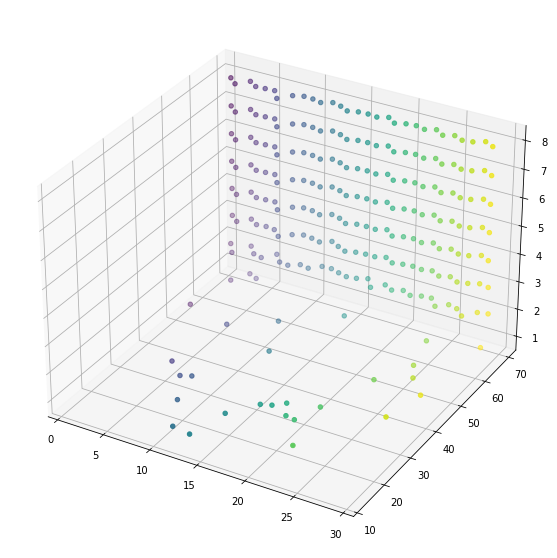

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdataset1, newdataset3, newdataset2, s=20, c = col)
plt.show()

In [136]:
col = np.arange(232)
#for i in range(0,46168) :
#    col[i] = ((col[i] % 199) +1)/20
col

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [137]:
46168%199

0